In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import pickle
from glob import glob
import numpy as np
import pandas as pd
import warnings
from copy import deepcopy
from scipy.interpolate import RegularGridInterpolator
from scipy.stats import chi2, gaussian_kde, norm
from scipy.special import erfinv, erf
from scipy.optimize import fmin_l_bfgs_b
from matplotlib.colors import LogNorm
import seaborn as sns

from settings import *
from tools import get_mids, ang_dist
from aeff_calculations import energy_smearing, aeff_eval_e_sd
from fluxes import (
    logE_reco_bins,
    normed_kvals,
    improved_normed_kvals,
    atmo_background,
    astro_flux,
    plot_spectrum,
    power_law,
    cut_off,
    parabola_index,
)


Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.


In [3]:
matplotlib = sns.mpl
plt = matplotlib.pyplot
plt.style.use("../style.mplstyle")
colorlist = plt.rcParams["axes.prop_cycle"].by_key()["color"]
warnings.filterwarnings("ignore")


In [4]:
print(LIVETIME)
print(GAMMA_ASTRO)
print(PHI_ASTRO)


315567360.0
2.28
1.44e-18


# Get the effective areas based on "alternative_plenum_aeff.ipynb"

We use here only upgoing events with dec>-5deg, since this is the threshold for a pure data set with few muons.

In [5]:
# use only upgoing data to mimick up-going muon track data set
with open("../resources/tabulated_logE_sindec_aeff_upgoing.pckl", "rb") as f:
    logE_bins, sindec_bins, aeff_2d = pickle.load(f)

logE_mids = get_mids(logE_bins)
ebins = np.power(10, logE_bins)
emids = get_mids(ebins)
ewidth = np.diff(ebins)
logE_reco_mids = get_mids(logE_reco_bins)

sindec_mids = get_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

ra_bins = np.linspace(0, np.pi * 2, num=101)
ra_mids = (ra_bins[1:] + ra_bins[:-1]) * 0.5
ra_width = ra_bins[1:] - ra_bins[:-1]
print(len(emids), "log_10(energy) bins")
print(len(sindec_mids), "declination bins")


40 log_10(energy) bins
50 declination bins


# Background

In [6]:
# MCEQ
with open("../resources/MCEq_flux.pckl", "rb") as f:
    (e_grid, zen), flux_def = pickle.load(f)
rgi = RegularGridInterpolator(
    (e_grid, -np.cos(np.deg2rad(zen))), np.log(flux_def["numu_conv"])
)
ee, ss = np.meshgrid(emids, sindec_mids)
spl_vals = np.exp(rgi((ee, ss)))


# Energy smearing with KDE

Text(0.5, 0, 'log(E true (neutrino) / GeV)')

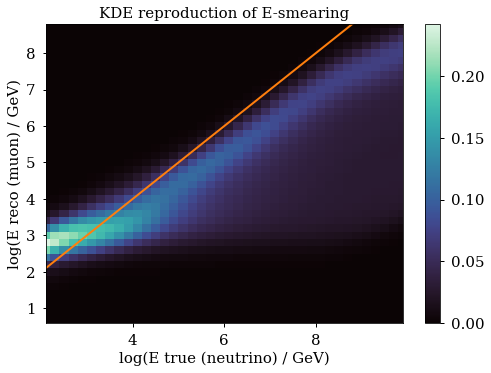

In [7]:
# logE_mids are the same as for effective area binning
egrid_true, egrid_reco = np.meshgrid(logE_mids, logE_reco_mids)

plt.grid(False)
plt.pcolormesh(egrid_true, egrid_reco, normed_kvals)
plt.colorbar()
plt.plot([1, 9], [1, 9], color="tab:orange")
plt.ylim(np.min(egrid_reco), np.max(egrid_reco))
plt.xlim(np.min(egrid_true), np.max(egrid_true))
plt.title("KDE reproduction of E-smearing")
plt.ylabel("log(E reco (muon) / GeV)")
plt.xlabel("log(E true (neutrino) / GeV)")


## Improved energy resolution for lower energies

Text(0.5, 0, 'log(E true (neutrino) / GeV)')

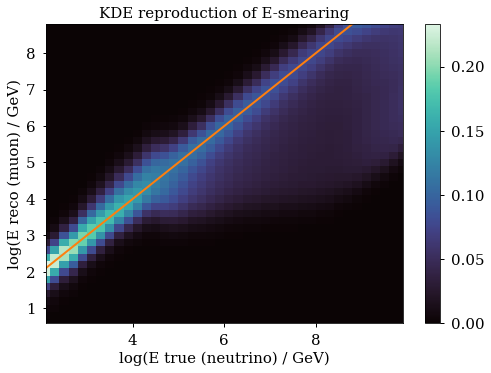

In [8]:
plt.grid(False)
plt.pcolormesh(egrid_true, egrid_reco, improved_normed_kvals)
plt.colorbar()
plt.plot([1, 9], [1, 9], color="tab:orange")
plt.ylim(np.min(egrid_reco), np.max(egrid_reco))
plt.xlim(np.min(egrid_true), np.max(egrid_true))
plt.title("KDE reproduction of E-smearing")
plt.ylabel("log(E reco (muon) / GeV)")
plt.xlabel("log(E true (neutrino) / GeV)")

# Test event numbers

## full sky

In [9]:
aeff_factor = (
    aeff_eval_e_sd(aeff_2d["IceCube"], sindec_width, ewidth, ra_width) * LIVETIME
)
astro_ev = astro_flux(
    "powerlaw",
    aeff_factor,
    emids,
    E_NORM,
    GAMMA_ASTRO,
    1,
    phi_0 = PHI_ASTRO,
    smear_energy=False,
)
print("original sum astro:", np.sum(astro_ev))
print(
    "smeared sum astro:",
    np.sum(energy_smearing(normed_kvals, astro_ev)),
    np.sum(energy_smearing(improved_normed_kvals, astro_ev)),
    "(should be numerically the same)",
)


original sum astro: 2338.175466622742
smeared sum astro: 2338.175466622742 2338.175466622742 (should be numerically the same)


# NGC 1068

In [10]:
# find the right lower bin boundary/ bin index for NGC1068's declination
ngc_bin_index = np.digitize(np.sin(ngc1068.dec.rad), sindec_bins)
# livetime of 10yr PS data
lt_10yr = (376.4 + 352.6 + 316.0 + 332.9 + 2198.2) * 24 * 3600

# 10yr PS PAPER PARAMETERS
GAMMA_NGC = 3.2
PHI_NGC = 3E-14
E0_NGC = 1E3
# PHI_NGC = PHI_PS * (E_NORM / 1e3) ** (-GAMMA_NGC)  # -> 2E-20


### Expected energy distribution

(10, 10000000.0)

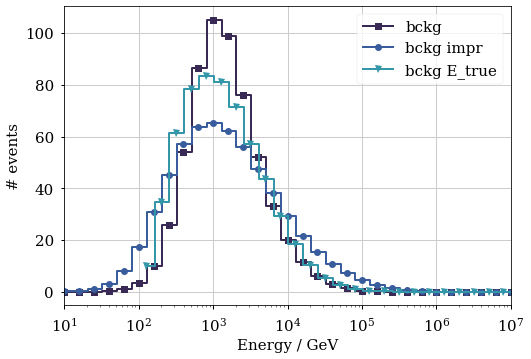

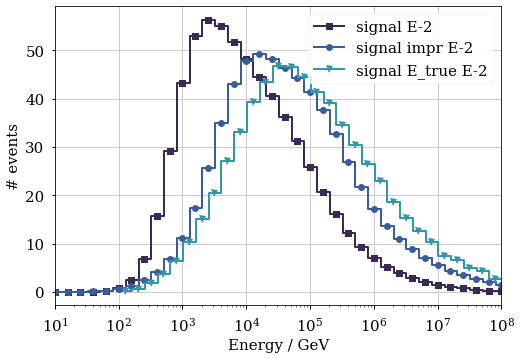

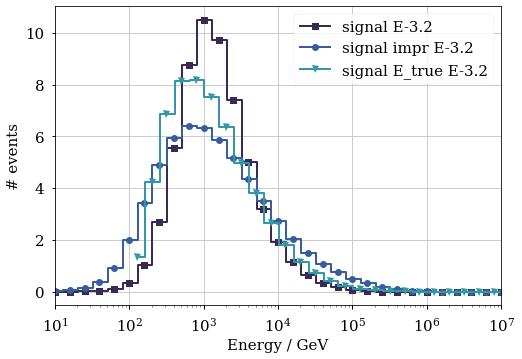

In [125]:
# we only need the (average) effective area at the location of NGC1068
# since the solid angle of this analysis is small enough
# background expectation
delta_psi = 2
aeff_factor = (
    aeff_2d["IceCube"][:, ngc_bin_index]
    * lt_10yr
    * ewidth
    * (np.deg2rad(delta_psi) ** 2)
    * np.pi  # solid angle approx.
)

plt.figure()
plt.plot(
    10 ** (logE_reco_mids),
    atmo_background(aeff_factor, spl_vals[ngc_bin_index], normed_kvals=normed_kvals),
    label="bckg",
    drawstyle="steps-mid",
    marker="s",
)
plt.plot(
    10 ** (logE_reco_mids),
    atmo_background(
        aeff_factor, spl_vals[ngc_bin_index], normed_kvals=improved_normed_kvals
    ),
    label="bckg impr",
    drawstyle="steps-mid",
    marker="o",
)
plt.plot(
    10 ** (logE_mids),
    atmo_background(
        aeff_factor, spl_vals[ngc_bin_index], smear_energy=False
    ),
    label="bckg E_true",
    drawstyle="steps-mid",
    marker="v",
)

plt.xscale("log")
plt.legend(loc=0)
plt.ylabel("# events")
plt.xlabel("Energy / GeV")
plt.xlim(10, 1E7)

# signal
plt.figure()
# calculate events per ngc pixel with newest 'science' NGC1068 flux
aeff_factor = aeff_2d["IceCube"][:, ngc_bin_index] * lt_10yr * ewidth
# flux is already integrated over solid angle, because it's a point source
plt.plot(
    10 ** (logE_reco_mids),
    astro_flux("powerlaw", aeff_factor, emids, E0_NGC, 2, 1, phi_0=PHI_NGC, normed_kvals=normed_kvals),
    label="signal E-2",
    drawstyle="steps-mid",
    marker="s",
)

plt.plot(
    10 ** (logE_reco_mids),
    astro_flux("powerlaw", aeff_factor, emids, E0_NGC, 2, 1, phi_0=PHI_NGC, normed_kvals=improved_normed_kvals),
    label="signal impr E-2",
    drawstyle="steps-mid",
    marker="o",
)

plt.plot(
    10 ** (logE_mids),
    astro_flux("powerlaw", aeff_factor, emids, E0_NGC, 2, 1, phi_0=PHI_NGC, smear_energy=False),
    label="signal E_true E-2",
    drawstyle="steps-mid",
    marker="v",
)

plt.xscale("log")
plt.legend(loc=0)
plt.ylabel("# events")
plt.xlabel("Energy / GeV")
plt.xlim(10, 1E8)

plt.figure()
# calculate events per ngc pixel with newest 'science' NGC1068 flux
aeff_factor = aeff_2d["IceCube"][:, ngc_bin_index] * lt_10yr * ewidth
# flux is already integrated over solid angle, because it's a point source
plt.plot(
    10 ** (logE_reco_mids),
    astro_flux("powerlaw", aeff_factor, emids, E0_NGC, 3.2, 1, phi_0=PHI_NGC, normed_kvals=normed_kvals),
    label="signal E-3.2",
    drawstyle="steps-mid",
    marker="s",
)

plt.plot(
    10 ** (logE_reco_mids),
    astro_flux("powerlaw", aeff_factor, emids, E0_NGC, 3.2, 1, phi_0=PHI_NGC, normed_kvals=improved_normed_kvals),
    label="signal impr E-3.2",
    drawstyle="steps-mid",
    marker="o",
)

plt.plot(
    10 ** (logE_mids),
    astro_flux("powerlaw", aeff_factor, emids, E0_NGC, 3.2, 1, phi_0=PHI_NGC, smear_energy=False),
    label="signal E_true E-3.2",
    drawstyle="steps-mid",
    marker="v",
)

plt.xscale("log")
plt.legend(loc=0)
plt.ylabel("# events")
plt.xlabel("Energy / GeV")
plt.xlim(10, 1E7)

## PSF-Energy functions from the smearing matrix

In [13]:
public_data_hist = np.genfromtxt("../resources/IC86_II_smearing.csv", skip_header=1)

logE_sm_min, logE_sm_max = public_data_hist[:, 0], public_data_hist[:, 1]
logE_sm_mids = (logE_sm_min + logE_sm_max) / 2.0
dec_sm_min, dec_sm_max = public_data_hist[:, 2], public_data_hist[:, 3]
dec_sm_mids = (dec_sm_min + dec_sm_max) / 2.0
log_psf_min, log_psf_max = np.log10(public_data_hist[:, 6]), np.log10(
    public_data_hist[:, 7]
)
psf_mids = (public_data_hist[:, 6] + public_data_hist[:, 7]) / 2.0
log_psf_mids = np.log10(psf_mids)
fractional_event_counts = public_data_hist[:, 10]


$f_x(x) = kde(x)$ with $ x = \log_{10}(y) \Leftrightarrow y = 10^x$

Transform: $z = y² = 10^{(2\cdot x)}$ with $ x = \frac{\log_{10}(z)}{2} := g(z)$

$\Rightarrow f_z(z) = | \frac{d}{dz} g(z) | \cdot f(g(z)) = \frac{1}{2\cdot z \cdot \log(10)} kde(\frac{\log_{10}(z)}{2})$

# Full 2D psi-energy LLH of NGC 1068

In [14]:
## set up the psi2-energy function and binning
mask = dec_sm_mids == 0
e_psi_kdes = gaussian_kde(
    (logE_sm_mids[mask], log_psf_mids[mask]), weights=fractional_event_counts[mask]
)

# psi² representation
delta_psi = 2
bins_per_psi2 = 25
psi2_bins = np.linspace(0, delta_psi**2, delta_psi**2 * bins_per_psi2 + 1)
psi2_mids = get_mids(psi2_bins)
log_psi_mids = np.log10(np.sqrt(psi2_mids))
# KDE was produced in log(E_true) and log(Psi)
e_eval, psi_eval = np.meshgrid(logE_mids, log_psi_mids)
psi_kvals = e_psi_kdes([e_eval.flatten(), psi_eval.flatten()]).reshape(
    len(log_psi_mids), len(logE_mids)
)

# new grid for analysis in psi^2 and e_reco after energy smearing
e_grid, psi_grid = np.meshgrid(logE_mids, psi2_mids)
e_psi2_grid = psi_kvals / psi_grid / 2 / np.log(10)
# normalize per energy to ensure that signal event numbers are not changed
e_psi2_grid /= np.sum(e_psi2_grid, axis=0)
bckg_grid = np.ones_like(e_psi2_grid)
bckg_grid /= np.sum(bckg_grid, axis=0)


In [15]:
def ps_llh_2d_composite(
    x,
    mu_b_base,
    mu_s_base,
    k_i,
    e_0=E0_NGC,
    phi_0=PHI_NGC,
    shape="powerlaw",
    normed_kvals=normed_kvals,
):
    """fit parameters in x:
    for the standard power law:
    x[0]: background normalization scaling
    x[1]: signal spectral index
    x[2]: signal normalization scaling

    see 'astro_flux' for further shapes and parameters

    mu_b_base: effective area factor for background
    mu_s_base: effective area factor for signal
    k_i: observation/asimov data
    e_norm: normalization energy, default E0_NGC
    phi_0: normalization flux, default PHI_NGC
    shape: flux shape, default 'powerlaw'
    """

    mu_b = atmo_background(
        mu_b_base * x[0], spl_vals[ngc_bin_index], normed_kvals=normed_kvals
    )
    mu_s = astro_flux(
        shape, mu_s_base, emids, e_0, *x[1:], phi_0=phi_0, normed_kvals=normed_kvals
    )
    mu_i = mu_s + mu_b

    return -2 * np.sum(
        np.where(
            mu_i > 0,
            k_i * np.log(mu_i)
            - mu_i
            - 0.5 * np.log(2 * np.pi * k_i)
            + k_i
            - k_i * np.log(k_i),
            0,
        )
    )


def ps_llh_2d_local(
    x, fixed_params, free_positions, fixed_params_positions, *args, **kwargs
):
    r"""Reduce full likelihood function with fixed parameters, i.e. reduce to
    a 'local' likelihood function. Free and fixed parameters are combined in one
    array to be piped through to 'spectral_ts_func'.
    -----------------------------------------------------------------------

    x: free parameters, piped through to 'spectral_ts_func'
    fixed_params: value of fixed parameters
    free_positions: array indices of free parameters
    fixed_params_positions: array indices of fixed parameters
    *args/**kwargs: piped through to 'spectral_ts_func'

    returns spectral_ts_func(free_and_fixed_parameters, *args)
    """
    all_x = np.zeros(len(x) + len(fixed_params))
    for i, pos in enumerate(fixed_params_positions):
        all_x[pos] = fixed_params[i]
    for i, pos in enumerate(free_positions):
        all_x[pos] = x[i]
    return ps_llh_2d_composite(all_x, *args, **kwargs)


### Significance test Background vs. Background + Signal

IceCube
Asimov data sum:
Background: 601.8278832251034
Signal: 59.95044518157612
(array([1.09961477]), -33919.94316239278, {'grad': array([0.00145519]), 'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'funcalls': 12, 'nit': 3, 'warnflag': 0})
(array([1.00004547, 3.20007137, 0.99982268]), -33928.875896963145, {'grad': array([ 0.03201421,  0.00291038, -0.0007276 ]), 'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'funcalls': 52, 'nit': 11, 'warnflag': 0})
P-VALUE: 0.011488976308888982 SIGNIFICANCE: 2.527463507506735
58.698057993055095
Plenum-1
Asimov data sum:
Background: 2394.2184505947894
Signal: 239.72793279162258
(array([1.10012775]), -28868.819957823667, {'grad': array([-0.0003638]), 'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'funcalls': 14, 'nit': 4, 'warnflag': 0})
(array([1.00000023, 3.19998573, 0.99998032]), -28902.722862425235, {'grad': array([-0.00618456, -0.0003638 , -0.00109139]), 'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'

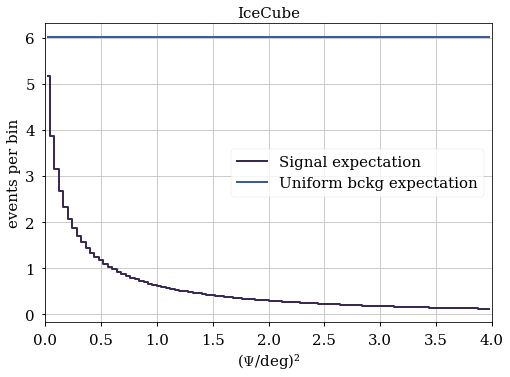

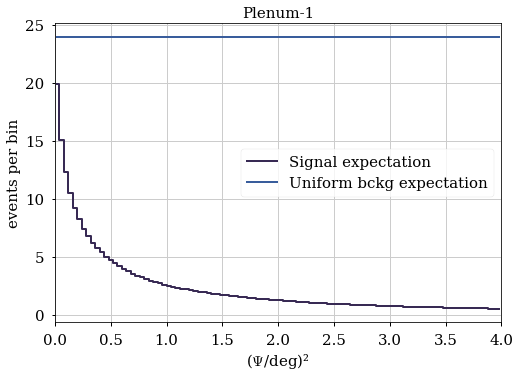

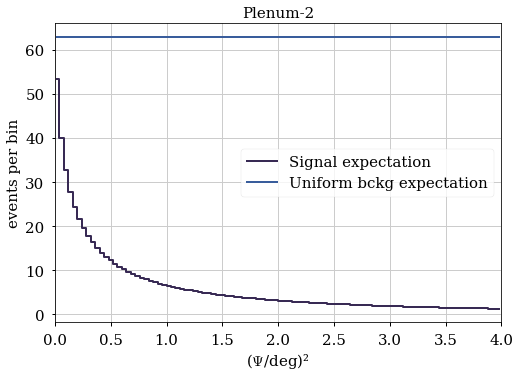

In [16]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
for ident in idents:
    print(ident)

    aeff_factor_bckg = (
        aeff_2d[ident][:, ngc_bin_index]
        * LIVETIME
        * ewidth
        * (np.deg2rad(delta_psi) ** 2)
        * np.pi  # solid angle approx.
    ) * bckg_grid
    if "Plenum" in ident:
        aeff_factor_bckg += (
            aeff_2d["IceCube"][:, ngc_bin_index]
            * LIVETIME
            * ewidth
            * (np.deg2rad(delta_psi) ** 2)
            * np.pi  # solid angle approx.
        ) * bckg_grid

    aeff_factor_signal = (
        aeff_2d[ident][:, ngc_bin_index] * LIVETIME * ewidth * e_psi2_grid
    )
    if "Plenum" in ident:
        aeff_factor_signal += (
            aeff_2d["IceCube"][:, ngc_bin_index] * LIVETIME * ewidth * e_psi2_grid
        )
    # model expectation for fitting
    mu_b_base = deepcopy(aeff_factor_bckg)
    mu_s_base = deepcopy(aeff_factor_signal)

    # asimov data
    k_b = atmo_background(aeff_factor_bckg, spl_vals[ngc_bin_index])
    k_s = astro_flux(
        "powerlaw",
        aeff_factor_signal,
        emids,
        E0_NGC,
        GAMMA_NGC,
        1,
        phi_0=PHI_NGC,
    )
    k_i = k_s + k_b

    print("Asimov data sum:")
    print("Background:", np.sum(k_b))
    print("Signal:", np.sum(k_s))

    # define the fitting functions with all parameters
    local_llh = lambda x: ps_llh_2d_local(
        x,
        (3, 0),
        (0,),
        (1, 2),
        mu_b_base,
        mu_s_base,
        k_i,
    )
    global_llh = lambda x: ps_llh_2d_composite(
        x, mu_b_base, mu_s_base, k_i
    )
    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1.2,),
        approx_grad=True,
    )
    print(out_bckg)

    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1.2, 3.0, 1.2),
        approx_grad=True,
    )
    print(out_comp)

    pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
    significance = erfinv(1 - pval) * np.sqrt(2)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)

    plt.figure()
    plt.title(ident)
    plt.plot(psi2_mids, np.sum(k_s, axis=-1), ds="steps-mid", label="Signal expectation")
    plt.plot(psi2_mids, np.sum(k_b, axis=-1), ds="steps-mid", label="Uniform bckg expectation")
    plt.xlabel(r"($\Psi$/deg)²")
    plt.ylabel("events per bin")
    plt.xlim(0, 4)
    # plt.ylim(9E-2, 20)
    # plt.ylim(0, 13)
    print(np.sum(astro_ev))
    plt.legend()



## 1D scan of power-law parameters

In [17]:
idents = ["IceCube", "Plenum-1", "Plenum-2", "Gen-2"]
num = 50
gamma_astro_scaling = np.linspace(2.5, 3.8, num=num + 1)
astro_scaling = np.logspace(-1.5, 0.3, num=num)
bf_SPL = {"ts": {}, "conv": {}, "gamma": {}, "phi_astro": {}}
local_SPL_gamma_scan = {"ts": {}, "conv": {}, "phi_astro": {}}
local_SPL_phi_scan = {"ts": {}, "conv": {}, "gamma": {}}
shape = "powerlaw"

for ident in idents:
    print(ident)

    aeff_factor_bckg = (
        aeff_2d[ident][:, ngc_bin_index]
        * LIVETIME
        * ewidth
        * (np.deg2rad(delta_psi) ** 2)
        * np.pi  # solid angle approx.
    ) * bckg_grid
    if "Plenum" in ident:
        aeff_factor_bckg += (
            aeff_2d["IceCube"][:, ngc_bin_index]
            * LIVETIME
            * ewidth
            * (np.deg2rad(delta_psi) ** 2)
            * np.pi  # solid angle approx.
        ) * bckg_grid

    aeff_factor_signal = (
        aeff_2d[ident][:, ngc_bin_index] * LIVETIME * ewidth * e_psi2_grid
    )
    if "Plenum" in ident:
        aeff_factor_signal += (
            aeff_2d["IceCube"][:, ngc_bin_index] * LIVETIME * ewidth * e_psi2_grid
        )
    # model expectation for fitting
    mu_b_base = deepcopy(aeff_factor_bckg)
    mu_s_base = deepcopy(aeff_factor_signal)

    # asimov data
    k_b = atmo_background(aeff_factor_bckg, spl_vals[ngc_bin_index])
    k_s = astro_flux(
        "powerlaw", aeff_factor_signal, emids, E0_NGC, GAMMA_NGC, 1, phi_0=PHI_NGC
    )
    k_i = k_s + k_b

    print("Asimov data sum:")
    print("Background:", np.sum(k_b))
    print("Signal:", np.sum(k_s))

    ## global minimum
    out = fmin_l_bfgs_b(
        ps_llh_2d_composite,
        x0=(1.2, 2.8, 1.2),
        approx_grad=True,
        args=(mu_b_base, mu_s_base, k_i),
    )
    if out[2]["warnflag"] != 0:
        print("WARNING!!")
    print("bf param:", out[0])

    bf_SPL["ts"][ident] = out[1]
    bf_SPL["conv"][ident] = out[0][0]
    bf_SPL["gamma"][ident] = out[0][1]
    bf_SPL["phi_astro"][ident] = out[0][2]

    print("starting local gamma scan...")
    local_SPL_gamma_scan["ts"][ident] = np.zeros(len(gamma_astro_scaling))
    local_SPL_gamma_scan["conv"][ident] = np.zeros(len(gamma_astro_scaling))
    local_SPL_gamma_scan["phi_astro"][ident] = np.zeros(len(gamma_astro_scaling))
    for j, gas in enumerate(gamma_astro_scaling):
        # local min with fixed gamma
        local_out = fmin_l_bfgs_b(
            ps_llh_2d_local,
            x0=(1.2, 1.2),
            bounds=[(0.1, 3), (0.1, 3)],
            approx_grad=True,
            args=((gas,), (0, 2), (1, ), mu_b_base, mu_s_base, k_i),
        )
        if local_out[2]["warnflag"] != 0:
            print("WARNING!!")
            print("bf param:", local_out[0])
        local_SPL_gamma_scan["conv"][ident][j], local_SPL_gamma_scan["phi_astro"][ident][j] = local_out[0]
        local_SPL_gamma_scan["ts"][ident][j] = local_out[1]

    print("starting local phi scan...")
    local_SPL_phi_scan["ts"][ident] = np.zeros(len(astro_scaling))
    local_SPL_phi_scan["conv"][ident] = np.zeros(len(astro_scaling))
    local_SPL_phi_scan["gamma"][ident] = np.zeros(len(astro_scaling))
    for j, asc in enumerate(astro_scaling):
        # local min with fixed phi_astro
        local_out = fmin_l_bfgs_b(
            ps_llh_2d_local,
            x0=(1.2, 2.8),
            bounds=[(0.1, 3), (1, 6)],
            approx_grad=True,
            args=((asc,), (0, 1), (2, ), mu_b_base, mu_s_base, k_i),
        )
        if local_out[2]["warnflag"] != 0:
            print("WARNING!!")
            print("bf param:", local_out[0])
        local_SPL_phi_scan["conv"][ident][j], local_SPL_phi_scan["gamma"][ident][j]= local_out[0]
        local_SPL_phi_scan["ts"][ident][j] = local_out[1]
    print("done")


IceCube
Asimov data sum:
Background: 601.8278832251034
Signal: 59.95044518157612
bf param: [1.0000923  3.19921658 0.99895399]
starting local gamma scan...
starting local phi scan...
done
Plenum-1
Asimov data sum:
Background: 2394.2184505947894
Signal: 239.72793279162258
bf param: [1.00012076 3.19877139 0.99835723]
starting local gamma scan...
starting local phi scan...
done
Plenum-2
Asimov data sum:
Background: 6292.103525797713
Signal: 628.0116132897438
bf param: [1.00002768 3.19974458 0.99964449]
starting local gamma scan...
starting local phi scan...
done
Gen-2
Asimov data sum:
Background: 4499.712958428027
Signal: 448.2341256796974
bf param: [1.00006383 3.1994183  0.99913465]
starting local gamma scan...
starting local phi scan...
done


Text(0, 0.5, '-2$\\Delta$LLH')

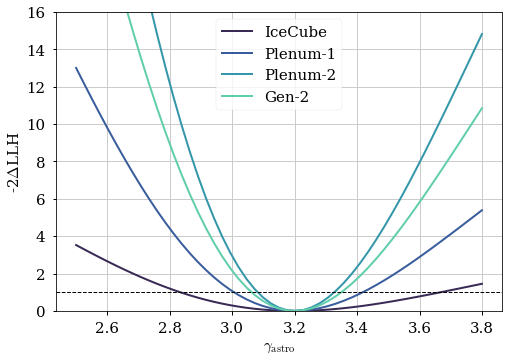

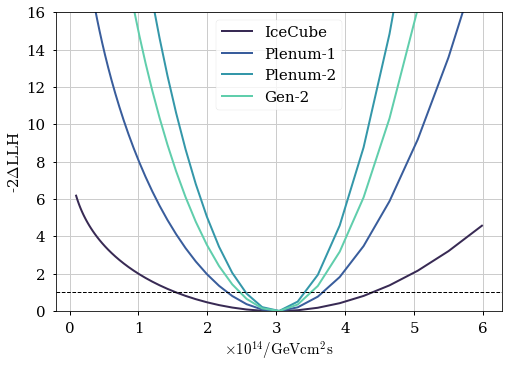

In [18]:
plt.figure()
for ident in idents:
    # mask invalid values where the fit failed
    mask = np.ones_like(local_SPL_gamma_scan["ts"][ident], dtype=bool)
    #mask = local_SPL_gamma_scan["ts"][ident] >= bf_SPL["ts"][ident]
    plt.plot(
        gamma_astro_scaling[mask],
        local_SPL_gamma_scan["ts"][ident][mask] - bf_SPL["ts"][ident],
        label=ident,
    )
plt.axhline(1, ls="--", color="k", lw=1)
plt.ylim(0, 16)
#plt.xlim(2.1, 2.4)
plt.legend(loc="upper center")
plt.xlabel(r"$\gamma_{\rm astro}$")
plt.ylabel(r"-2$\Delta$LLH")

plt.figure()
for ident in idents:
    # mask invalid values where the fit failed
    mask = np.ones_like(local_SPL_phi_scan["ts"][ident], dtype=bool)
    #mask = local_SPL_gamma_scan["ts"][ident] >= bf_SPL["ts"][ident]
    plt.plot(
        astro_scaling[mask] * (PHI_NGC * 1E14),
        local_SPL_phi_scan["ts"][ident][mask] - bf_SPL["ts"][ident],
        label=ident,
    )
plt.axhline(1, ls="--", color="k", lw=1)
plt.ylim(0, 16)
plt.legend(loc="upper center")
plt.xlabel(r"$\times 10^{14} / \rm GeV cm^2 s$")
plt.ylabel(r"-2$\Delta$LLH")


## 2D scan - parameters of 10yr PS Paper

IceCube
Asimov data sum:
Background: 601.8278832251034
Signal: 59.95044518157612
bf param: [1.0000923  3.19921658 0.99895399]
starting local fits...
done
Plenum-1
Asimov data sum:
Background: 2394.2184505947894
Signal: 239.72793279162258
bf param: [1.00012076 3.19877139 0.99835723]
starting local fits...
done
Plenum-2
Asimov data sum:
Background: 6292.103525797713
Signal: 628.0116132897438
bf param: [1.00002768 3.19974458 0.99964449]
starting local fits...
done
IceCube
Plenum-1
Plenum-2


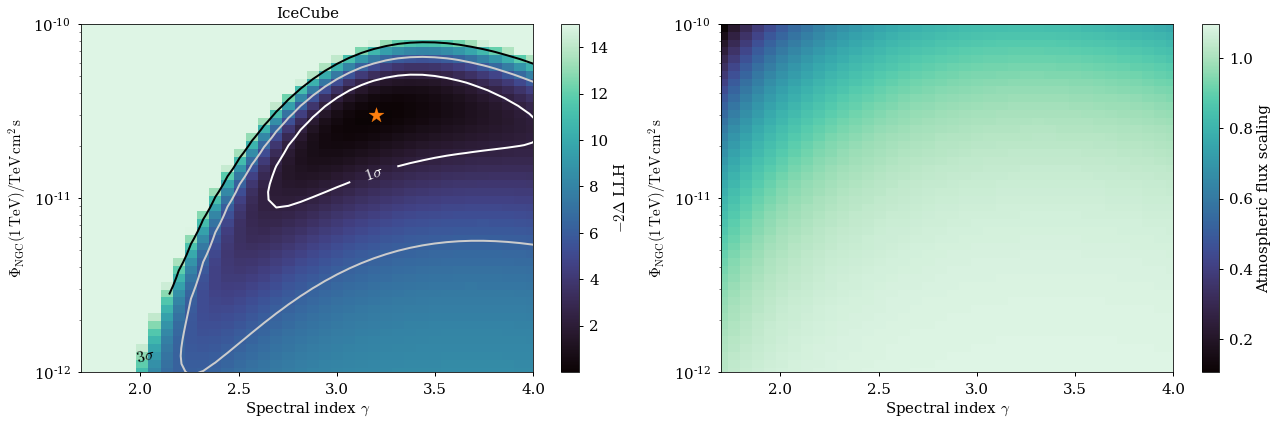

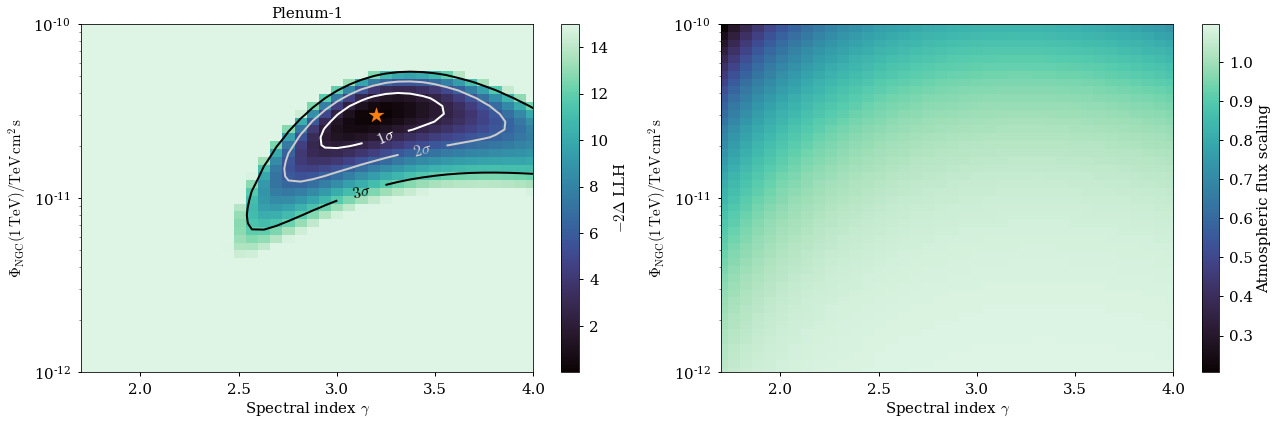

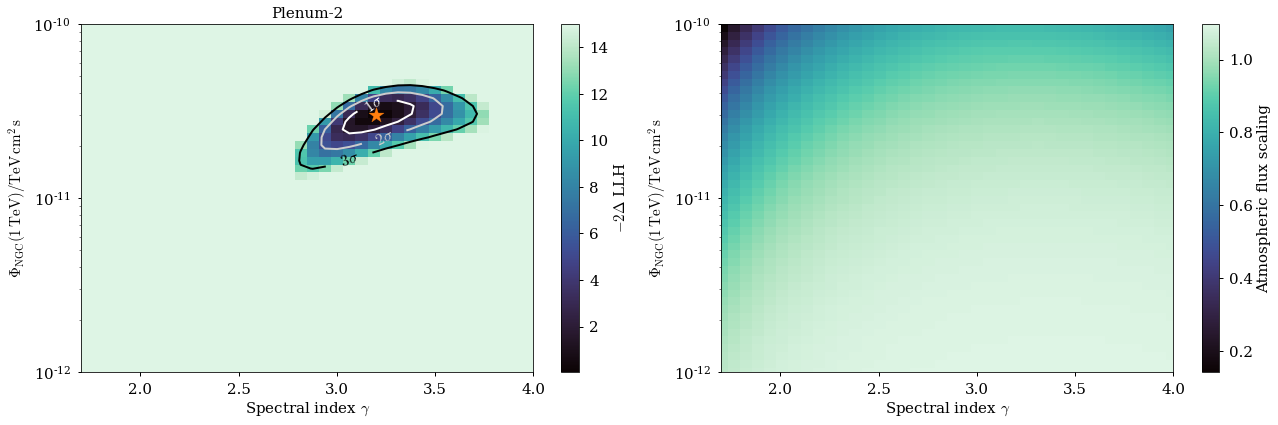

In [20]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
num = 50
gamma_astro_scaling = np.linspace(1.7, 4.8, num=num + 1)
astro_scaling = np.logspace(-1.7, 0.5, num=num)
bf_SPL = {"ts": {}, "conv": {}, "gamma": {}, "phi_astro": {}}
local_SPL = {"ts": {}, "conv": {}}
shape = "powerlaw"


for ident in idents:
    print(ident)

    aeff_factor_bckg = (
        aeff_2d[ident][:, ngc_bin_index]
        * LIVETIME
        * ewidth
        * (np.deg2rad(delta_psi) ** 2)
        * np.pi  # solid angle approx.
    ) * bckg_grid
    if "Plenum" in ident:
        aeff_factor_bckg += (
            aeff_2d["IceCube"][:, ngc_bin_index]
            * LIVETIME
            * ewidth
            * (np.deg2rad(delta_psi) ** 2)
            * np.pi  # solid angle approx.
        ) * bckg_grid

    aeff_factor_signal = (
        aeff_2d[ident][:, ngc_bin_index] * LIVETIME * ewidth * e_psi2_grid
    )
    if "Plenum" in ident:
        aeff_factor_signal += (
            aeff_2d["IceCube"][:, ngc_bin_index] * LIVETIME * ewidth * e_psi2_grid
        )
    # model expectation for fitting
    mu_b_base = deepcopy(aeff_factor_bckg)
    mu_s_base = deepcopy(aeff_factor_signal)

    # asimov data
    k_b = atmo_background(aeff_factor_bckg, spl_vals[ngc_bin_index])
    k_s = astro_flux(
        "powerlaw", aeff_factor_signal, emids, E0_NGC, GAMMA_NGC, 1, phi_0=PHI_NGC
    )
    k_i = k_s + k_b

    print("Asimov data sum:")
    print("Background:", np.sum(k_b))
    print("Signal:", np.sum(k_s))

    ## global minimum
    out = fmin_l_bfgs_b(
        ps_llh_2d_composite,
        x0=(1.2, 2.8, 1.2),
        approx_grad=True,
        args=(mu_b_base, mu_s_base, k_i),
    )
    if out[2]["warnflag"] != 0:
        print("WARNING!!")
    print("bf param:", out[0])

    bf_SPL["ts"][ident] = out[1]
    bf_SPL["conv"][ident] = out[0][0]
    bf_SPL["gamma"][ident] = out[0][1]
    bf_SPL["phi_astro"][ident] = out[0][2]

    local_SPL["ts"][ident] = np.zeros((num, num + 1))
    local_SPL["conv"][ident] = np.zeros((num, num + 1))
    print("starting local fits...")
    for i, asc in enumerate(astro_scaling):
        for j, gas in enumerate(gamma_astro_scaling):
            # local min with fixed phi_astro
            local_out = fmin_l_bfgs_b(
                ps_llh_2d_local,
                x0=(1.2,),
                bounds=[(0.1, 3)],
                approx_grad=True,
                args=((gas, asc), (0,), (1, 2), mu_b_base, mu_s_base, k_i),
            )
            if local_out[2]["warnflag"] != 0:
                print("WARNING!!")
                print("bf param:", local_out[0])
            (local_SPL["conv"][ident][i][j],) = local_out[0]
            local_SPL["ts"][ident][i][j] = local_out[1]
    print("done")


ref_color = "tab:orange"
# confidence levels
cvals = 1 - erf(np.arange(1, 4) / np.sqrt(2))
levels = chi2.isf(cvals, 2)
lbs = np.array([r"$1\sigma$", r"$2\sigma$", r"$3\sigma$"])
level_colors = ["w", "0.8", "k"]

for ident in idents:
    print(ident)
    f, axes = plt.subplots(ncols=2, figsize=(18, 6))
    ax = axes[0]
    # draw llh grid for gamma and astro flux
    im = ax.pcolormesh(
        gamma_astro_scaling,
        astro_scaling * PHI_NGC * 1e3,  # match 10yr paper plot of Tessa C.
        local_SPL["ts"][ident] - bf_SPL["ts"][ident],
        vmax=15,  # 6 is approx. the 95% quantile of a 2D LLH scan
    )
    cb = plt.colorbar(im, ax=ax)
    # draw contour levels

    sc = ax.contour(
        gamma_astro_scaling,
        astro_scaling * PHI_NGC * 1e3,  # match 10yr paper plot of Tessa C.
        local_SPL["ts"][ident] - bf_SPL["ts"][ident],
        levels=levels,
        colors=level_colors,
    )
    ## best fit point
    ax.scatter(
        bf_SPL["gamma"][ident],
        bf_SPL["phi_astro"][ident]
        * PHI_NGC
        * 1e3,  # match 10yr paper plot of Tessa C.
        marker="*",
        s=250,
        color="tab:orange",
    )
    fmt = {l: s for l, s in zip(sc.levels, lbs)}
    ax.clabel(sc, levels, fmt=fmt, fontsize=16)
    # ax.plot(
    #     diffuse_10yr_ref[:, 0],
    #     diffuse_10yr_ref[:, 1],
    #     color=ref_color,
    #     label=r"9.5yr IC diffuse $\nu_\mu$, 95% CL",
    # )
    # ax.legend(loc=2)
    ax.set_ylabel(r"$\Phi_{\rm NGC} (1\,{\rm TeV}) / {\rm TeV\, cm^2\, s}$")
    ax.set_xlabel(r"Spectral index $\gamma$")
    cb.set_label(r"$-2 \Delta$ LLH")
    ax.set_title(ident)
    ax.set_yscale("log")
    ax.set_ylim(1e-12, 1e-10)
    ax.set_xlim(1.7, 4)

    # in addition, check the nuisance parameter of conventional flux
    ax = axes[1]
    im = ax.pcolormesh(
        gamma_astro_scaling,
        astro_scaling * PHI_NGC * 1e3,  # match 10yr paper plot of Tessa C.
        local_SPL["conv"][ident],
    )
    ax.set_ylabel(r"$\Phi_{\rm NGC} (1\,{\rm TeV}) / {\rm TeV\, cm^2\, s}$")
    ax.set_xlabel(r"Spectral index $\gamma$")
    cb = plt.colorbar(im, ax=ax)
    cb.set_label(r"Atmospheric flux scaling")
    ax.set_yscale("log")
    ax.set_ylim(1e-12, 1e-10)
    ax.set_xlim(1.7, 4)

    f.tight_layout()
    # f.savefig(f"../plots/2D_scan_diffuse_spl_{ident}.pdf")


# power law vs other shapes


In [102]:
# parabola parameters
Alpha_NGC = 1
Beta_NGC = 2
E_para_norm = 3E3

# cutoff parameters
Gamma_cut = 2
logE_cut = 4 # log10 (Ecut / GeV)

In [103]:
aeff_factor_signal = aeff_2d[ident][:, ngc_bin_index] * LIVETIME * ewidth * e_psi2_grid
astro_ev_sum_pl = np.sum(
    astro_flux(
        "powerlaw", aeff_factor_signal, emids, E0_NGC, GAMMA_NGC, 1, phi_0=PHI_NGC
    )
)

# parabola
astro_ev_sum_para = np.sum(astro_flux(
    "parabola",
    aeff_factor_signal,
    emids,
    E_para_norm,
    Alpha_NGC,
    1,
    Beta_NGC,
    phi_0=PHI_NGC,
))
# match event numbers
flux_scaling_para =astro_ev_sum_pl / astro_ev_sum_para
print("flux_scaling_para", flux_scaling_para)

# cutoff
astro_ev_sum_cut = np.sum(astro_flux(
    "powerlaw with cutoff",
    aeff_factor_signal,
    emids,
    E0_NGC,
    Gamma_cut,
    1,
    logE_cut,
    phi_0=PHI_NGC,
))
flux_scaling_cut = astro_ev_sum_pl / astro_ev_sum_cut
print("flux_scaling_cut", flux_scaling_cut)


flux_scaling_para 0.04482886645182618
flux_scaling_cut 0.6191590787356955


### Plot flux and event expectation

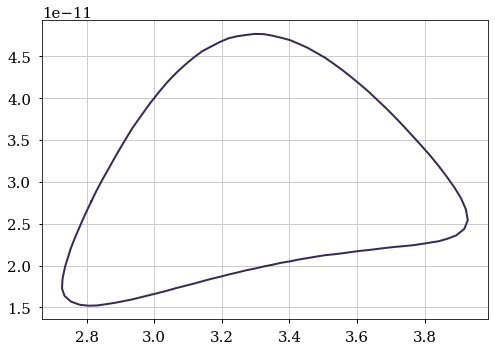

In [110]:
gamma_c_68, phi_c_68 = np.loadtxt("../resources/tenyr_paper_68_contour.txt")
plt.plot(gamma_c_68, phi_c_68)

parabola: 62.1923562655878
powerlaw with cutoff 61.51941728811294
power law: 59.95044518157613


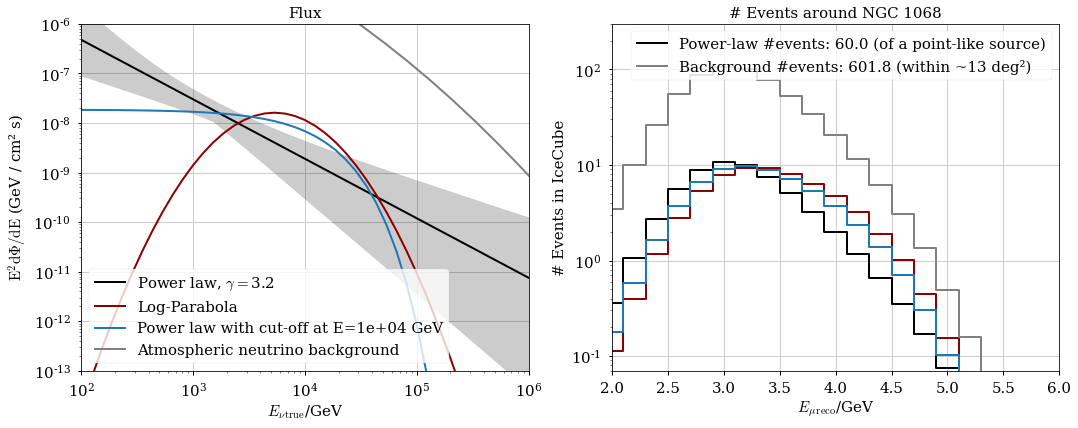

In [116]:
sq_deg = np.pi * delta_psi**2
x_evals = np.logspace(0, 9, 100)

pl = power_law(x_evals, E0_NGC, GAMMA_NGC, PHI_NGC)
cut = power_law(x_evals, E0_NGC, Gamma_cut, PHI_NGC * flux_scaling_cut) * cut_off(
    x_evals, 10**logE_cut
)
para_idx = parabola_index(Alpha_NGC, Beta_NGC, x_evals, E_para_norm)
para = power_law(x_evals, E_para_norm, para_idx, PHI_NGC * flux_scaling_para)

f, axes = plt.subplots(ncols=2, figsize=(15, 6))
ax = axes[0]
ax.set_title("Flux")

# error contour
c_low = np.zeros_like(x_evals)
c_high = np.zeros_like(x_evals)
for ii, xe in enumerate(x_evals):
    tmp = power_law(xe, E0_NGC, gamma_c_68, phi_c_68 / 1e3)
    c_low[ii] = np.min(tmp)
    c_high[ii] = np.max(tmp)
ax.fill_between(
    x_evals, c_low * (x_evals**2), c_high * (x_evals**2), color="k", alpha=0.2
)

ax.plot(
    x_evals,
    pl * (x_evals**2),
    label=rf"Power law, $\gamma=${GAMMA_NGC}",
    color="k",
    alpha=1,
)

ax.plot(x_evals, para * (x_evals**2), label="Log-Parabola", color="darkred")
ax.plot(
    x_evals,
    cut * (x_evals**2),
    label=f"Power law with cut-off at E={10**logE_cut:1.0e} GeV",
    color="tab:blue",
)
ax.plot(
    emids,
    spl_vals[ngc_bin_index] * (emids**2),
    label="Atmospheric neutrino background",
    color="gray",
)

ax.set_yscale("log")
ax.set_ylabel(r"$\rm E^2 d\Phi / dE$ (GeV / cm² s)")
ax.set_xscale("log")
ax.set_xlabel(r"$E_{\nu \, \rm true}$/GeV")
ax.set_ylim(1e-13, 1e-6)
ax.set_xlim(1e2, 1e6)
ax.legend(loc=3)


### plot Event numbers in E_reco
ax = axes[1]
ident = "IceCube"
aeff_factor_bckg = (
    aeff_2d[ident][:, ngc_bin_index]
    * LIVETIME
    * ewidth
    * (np.deg2rad(delta_psi) ** 2)
    * np.pi  # solid angle approx.
) * bckg_grid

aeff_factor_signal = aeff_2d[ident][:, ngc_bin_index] * LIVETIME * ewidth * e_psi2_grid
# model expectation for fitting
mu_b_base = deepcopy(aeff_factor_bckg)
mu_s_base = deepcopy(aeff_factor_signal)

for use_e_reco in [True]:  # , False]:
    # asimov data
    k_b = atmo_background(
        aeff_factor_bckg, spl_vals[ngc_bin_index], smear_energy=use_e_reco
    )

    # parabola
    k_s_par = astro_flux(
        "parabola",
        aeff_factor_signal,
        emids,
        E_para_norm,
        Alpha_NGC,
        flux_scaling_para,
        Beta_NGC,
        smear_energy=use_e_reco,
        phi_0=PHI_NGC,
    )
    print("parabola:", np.sum(k_s_par))

    # cutoff
    k_s_cut = astro_flux(
        "powerlaw with cutoff",
        aeff_factor_signal,
        emids,
        E0_NGC,
        Gamma_cut,
        flux_scaling_cut,
        logE_cut,
        smear_energy=use_e_reco,
        phi_0=PHI_NGC,
    )
    print("powerlaw with cutoff", np.sum(k_s_cut))

    # powerlaw
    k_s_pl = astro_flux(
        "powerlaw",
        aeff_factor_signal,
        emids,
        E0_NGC,
        GAMMA_NGC,
        1,
        smear_energy=use_e_reco,
        phi_0=PHI_NGC,
    )
    print("power law:", np.sum(k_s_pl))

    evals = logE_reco_mids if use_e_reco else logE_mids
    _ = plot_spectrum(
        evals,
        [
            np.sum(k_s_pl, axis=0),
            np.sum(k_s_par, axis=0),
            np.sum(k_s_cut, axis=0),
            np.sum(k_b, axis=0),
        ],
        [
            f"Power-law #events: {np.sum(k_s_pl):1.1f} (of a point-like source)",
            "",
            "",
            f"Background #events: {np.sum(k_b):1.1f} (within ~{sq_deg:1.0f} deg²)",
        ],
        "# Events around NGC 1068",
        f,
        ax,
        xlim=(2, 6),
        ylim=(7e-2, 3e2),
        color=["k", "darkred", "tab:blue", "gray"],
        xlabel=r"$E_{\mu \, \rm reco}$/GeV"
        if use_e_reco
        else r"$E_{\nu \, \rm true}$/GeV",
        ylabel="# Events in IceCube",
    )


## Parabola

### Significance

In [58]:
idents = ["IceCube", "Plenum-1", "Plenum-2", "Gen-2"]
for ident in idents:
    print(ident)

    aeff_factor_bckg = (
        aeff_2d[ident][:, ngc_bin_index]
        * LIVETIME
        * ewidth
        * (np.deg2rad(delta_psi) ** 2)
        * np.pi  # solid angle approx.
    ) * bckg_grid
    if "Plenum" in ident:
        aeff_factor_bckg += (
            aeff_2d["IceCube"][:, ngc_bin_index]
            * LIVETIME
            * ewidth
            * (np.deg2rad(delta_psi) ** 2)
            * np.pi  # solid angle approx.
        ) * bckg_grid


    aeff_factor_signal = (
        aeff_2d[ident][:, ngc_bin_index] * LIVETIME * ewidth * e_psi2_grid
    )
    if "Plenum" in ident:
        aeff_factor_signal += (
            aeff_2d["IceCube"][:, ngc_bin_index] * LIVETIME * ewidth * e_psi2_grid
        )
    # model expectation for fitting
    mu_b_base = deepcopy(aeff_factor_bckg)
    mu_s_base = deepcopy(aeff_factor_signal)

    # asimov data
    k_b = atmo_background(aeff_factor_bckg, spl_vals[ngc_bin_index])
    k_s = astro_flux(
        "parabola",
        aeff_factor_signal,
        emids,
        E_para_norm,
        Alpha_NGC,
        flux_scaling_para,
        Beta_NGC,
        phi_0=PHI_NGC,
    )
    k_i = k_s + k_b

    print("Asimov data sum:")
    print("Background:", np.sum(k_b))
    print("Signal:", np.sum(k_s))

    out_bckg = fmin_l_bfgs_b(
        ps_llh_2d_composite,
        x0=(1.2, 3.0, 1.2),
        approx_grad=True,
        args=(mu_b_base, mu_s_base, k_i),
    )
    print(out_bckg)

    # factor our the args because it's ugly the way I programmed it (:
    comp = lambda x: ps_llh_2d_composite(x, mu_b_base, mu_s_base, k_i, e_0=E_para_norm, shape="parabola")
    out_comp = fmin_l_bfgs_b(
        comp,
        x0=(1.2, 1.2, 0.05, 2.2),
        approx_grad=True,
    )
    print(out_comp)

    pval = chi2.sf(out_bckg[1] - out_comp[1], 1)
    significance = erfinv(1 - pval) * np.sqrt(2)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)


IceCube
Asimov data sum:
Background: 601.8278832251033
Signal: 59.95044518157615
(array([0.98032438, 2.80710445, 0.92407579]), -6074.5216092172095, {'grad': array([-0.00063665, -0.00081855,  0.00027285]), 'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'funcalls': 64, 'nit': 14, 'warnflag': 0})
(array([1.00006747, 0.97161581, 0.04287777, 2.03193953]), -6075.727661294707, {'grad': array([-0.0003638 , -0.00045475,  0.00336513,  0.0001819 ]), 'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'funcalls': 125, 'nit': 19, 'warnflag': 0})
P-VALUE: 0.2721154096666951 SIGNIFICANCE: 1.0982040236211141
Plenum-1
Asimov data sum:
Background: 2394.218450594789
Signal: 219.25045443817783
(array([0.98107578, 2.77012039, 0.85928934]), -5054.00330942175, {'grad': array([-0.01318767,  0.00109139, -0.00100044]), 'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'funcalls': 72, 'nit': 15, 'warnflag': 0})
(array([1.00006904, 0.97044254, 0.04288075, 2.0339043 ]), -5058.1858878831

### 2D scan

IceCube
Asimov data sum:
Background: 601.8278832251033
Signal: 59.95044518157615
bf param: [1.00006747 0.97161581 0.04287777 2.03193953]
starting local fits...
done
Plenum-1
Asimov data sum:
Background: 2394.218450594789
Signal: 219.25045443817783
bf param: [1.00006904 0.97044254 0.04288075 2.0339043 ]
starting local fits...
done
Plenum-2
Asimov data sum:
Background: 6292.103525797714
Signal: 607.534134936299
bf param: [1.00008715 0.97100524 0.04287128 2.03294467]
starting local fits...
WARNING!!
bf param: [0.98561949 0.005     ]
done
IceCube
Plenum-1
Plenum-2


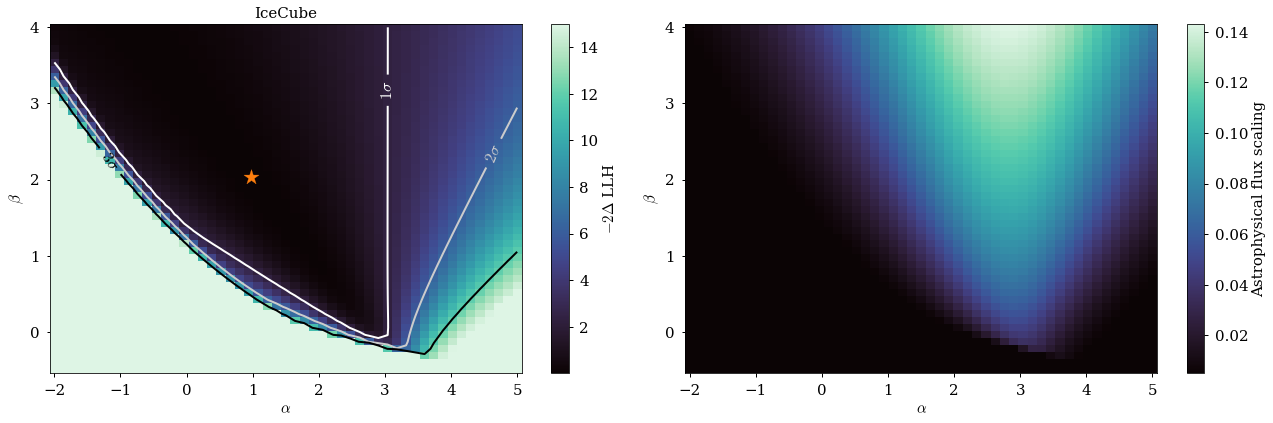

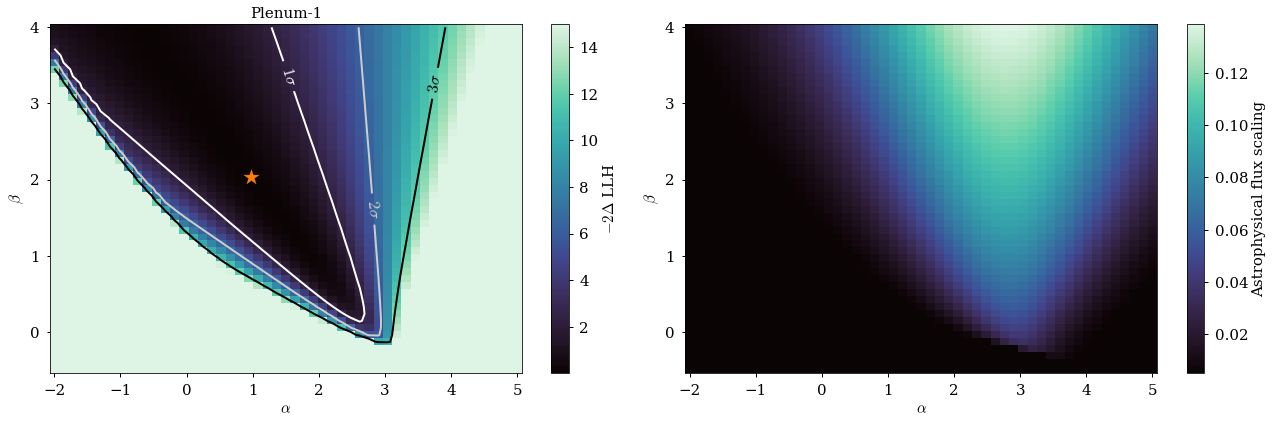

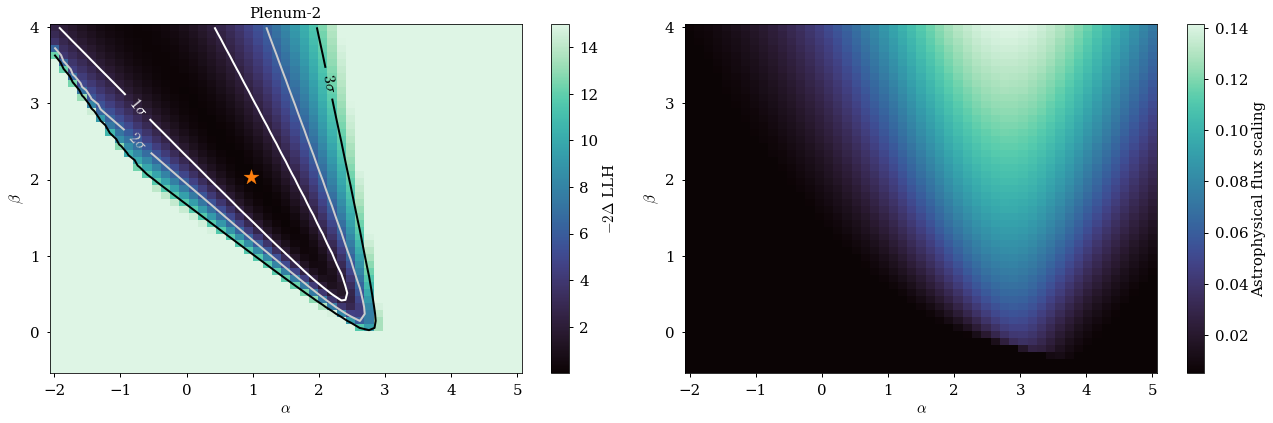

In [82]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
num = 50
alpha_astro_scaling = np.linspace(-2, 5, num=num + 1)
beta_astro_scaling = np.linspace(-0.5, 4, num=num)
bf_SPL = {"ts": {}, "conv": {}, "alpha": {}, "phi_astro": {}, "beta": {}}
local_SPL = {"ts": {}, "conv": {}, "phi_astro": {}}
shape = "powerlaw"


for ident in idents:
    print(ident)

    aeff_factor_bckg = (
        aeff_2d[ident][:, ngc_bin_index]
        * LIVETIME
        * ewidth
        * (np.deg2rad(delta_psi) ** 2)
        * np.pi  # solid angle approx.
    ) * bckg_grid
    if "Plenum" in ident:
        aeff_factor_bckg += (
            aeff_2d["IceCube"][:, ngc_bin_index]
            * LIVETIME
            * ewidth
            * (np.deg2rad(delta_psi) ** 2)
            * np.pi  # solid angle approx.
        ) * bckg_grid

    aeff_factor_signal = (
        aeff_2d[ident][:, ngc_bin_index] * LIVETIME * ewidth * e_psi2_grid
    )
    if "Plenum" in ident:
        aeff_factor_signal += (
            aeff_2d["IceCube"][:, ngc_bin_index] * LIVETIME * ewidth * e_psi2_grid
        )
    # model expectation for fitting
    mu_b_base = deepcopy(aeff_factor_bckg)
    mu_s_base = deepcopy(aeff_factor_signal)

    # asimov data
    k_b = atmo_background(aeff_factor_bckg, spl_vals[ngc_bin_index])
    k_s = astro_flux(
        "parabola",
        aeff_factor_signal,
        emids,
        E_para_norm,
        Alpha_NGC,
        flux_scaling_para,
        Beta_NGC,
        phi_0=PHI_NGC,
    )
    k_i = k_s + k_b

    print("Asimov data sum:")
    print("Background:", np.sum(k_b))
    print("Signal:", np.sum(k_s))

    ## global minimum
    comp = lambda x: ps_llh_2d_composite(x, mu_b_base, mu_s_base, k_i, e_0=E_para_norm, shape="parabola")
    out = fmin_l_bfgs_b(
        comp,
        x0=(1.2, 1.2, 0.05, 2.2),
        approx_grad=True,
    )
    if out[2]["warnflag"] != 0:
        print("WARNING!!")
    print("bf param:", out[0])

    bf_SPL["ts"][ident] = out[1]
    bf_SPL["conv"][ident] = out[0][0]
    bf_SPL["alpha"][ident] = out[0][1]
    bf_SPL["phi_astro"][ident] = out[0][2]
    bf_SPL["beta"][ident] = out[0][3]

    local_SPL["ts"][ident] = np.zeros((num, num + 1))
    local_SPL["conv"][ident] = np.zeros((num, num + 1))
    local_SPL["phi_astro"][ident] = np.zeros((num, num + 1))
    print("starting local fits...")
    for i, bsc in enumerate(beta_astro_scaling):
        for j, asc in enumerate(alpha_astro_scaling):
            func = lambda x: ps_llh_2d_local(x, (asc, bsc), (0, 2), (1, 3), mu_b_base, mu_s_base, k_i, e_0=E_para_norm, shape="parabola")
            local_out = fmin_l_bfgs_b(
                func,
                x0=(1.2, 0.05),
                bounds=[(0.1, 3), (0.005, 0.2)],
                approx_grad=True,
            )
            if local_out[2]["warnflag"] != 0:
                print("WARNING!!")
                print("bf param:", local_out[0])
            local_SPL["conv"][ident][i][j] = local_out[0][0]
            local_SPL["phi_astro"][ident][i][j] = local_out[0][1]
            local_SPL["ts"][ident][i][j] = local_out[1]
    print("done")

# confidence levels
cvals = 1 - erf(np.arange(1, 4) / np.sqrt(2))
levels = chi2.isf(cvals, 2)
lbs = np.array([r"$1\sigma$", r"$2\sigma$", r"$3\sigma$"])
level_colors = ["w", "0.8", "k"]

for ident in idents:
    print(ident)
    f, axes = plt.subplots(ncols=2, figsize=(18, 6))
    ax = axes[0]
    # draw llh grid for gamma and astro flux
    im = ax.pcolormesh(
        alpha_astro_scaling,
        beta_astro_scaling,
        local_SPL["ts"][ident] - bf_SPL["ts"][ident],
        vmax=15,  # 6 is approx. the 95% quantile of a 2D LLH scan
    )
    cb = plt.colorbar(im, ax=ax)
    # draw contour levels

    sc = ax.contour(
        alpha_astro_scaling,
        beta_astro_scaling,
        local_SPL["ts"][ident] - bf_SPL["ts"][ident],
        levels=levels,
        colors=level_colors,
    )
    ## best fit point
    ax.scatter(
        bf_SPL["alpha"][ident],
        bf_SPL["beta"][ident],
        marker="*",
        s=250,
        color="tab:orange",
    )
    fmt = {l: s for l, s in zip(sc.levels, lbs)}
    ax.clabel(sc, levels, fmt=fmt, fontsize=16)
    ax.set_ylabel(r"$\beta$")
    ax.set_xlabel(r"$\alpha$")
    cb.set_label(r"$-2 \Delta$ LLH")
    ax.set_title(ident)
    # ax.set_yscale("log")
    # ax.set_xscale("log")
    
    #ax.set_ylim(1e-12, 1e-10)
    #ax.set_xlim(1.7, 4)

    # in addition, check the "nuisance" parameter of astro flux normalization
    ax = axes[1]
    im = ax.pcolormesh(
        alpha_astro_scaling,
        beta_astro_scaling,
        local_SPL["phi_astro"][ident],
    )
    ax.set_ylabel(r"$\beta$")
    ax.set_xlabel(r"$\alpha$")
    cb = plt.colorbar(im, ax=ax)
    cb.set_label(r"Astrophysical flux scaling")
    # ax.set_yscale("log")
    # ax.set_xscale("log")
    
    #ax.set_ylim(1e-12, 1e-10)
    #ax.set_xlim(1.7, 4)

    f.tight_layout()
    # f.savefig(f"../plots/2D_scan_diffuse_spl_{ident}.pdf")


## Power-law with cutoff

### Significance

In [84]:
idents = ["IceCube", "Plenum-1", "Plenum-2", "Gen-2"]
for ident in idents:
    print(ident)

    aeff_factor_bckg = (
        aeff_2d[ident][:, ngc_bin_index]
        * LIVETIME
        * ewidth
        * (np.deg2rad(delta_psi) ** 2)
        * np.pi  # solid angle approx.
    ) * bckg_grid
    if "Plenum" in ident:
        aeff_factor_bckg += (
            aeff_2d["IceCube"][:, ngc_bin_index]
            * LIVETIME
            * ewidth
            * (np.deg2rad(delta_psi) ** 2)
            * np.pi  # solid angle approx.
        ) * bckg_grid


    aeff_factor_signal = (
        aeff_2d[ident][:, ngc_bin_index] * LIVETIME * ewidth * e_psi2_grid
    )
    if "Plenum" in ident:
        aeff_factor_signal += (
            aeff_2d["IceCube"][:, ngc_bin_index] * LIVETIME * ewidth * e_psi2_grid
        )
    # model expectation for fitting
    mu_b_base = deepcopy(aeff_factor_bckg)
    mu_s_base = deepcopy(aeff_factor_signal)

    # asimov data
    k_b = atmo_background(aeff_factor_bckg, spl_vals[ngc_bin_index])
    k_s = astro_flux(
        "powerlaw with cutoff",
        aeff_factor_signal,
        emids,
        E0_NGC,
        Gamma_cut,
        flux_scaling_cut,
        logE_cut,
        phi_0=PHI_NGC,
    )
    k_i = k_s + k_b

    print("Asimov data sum:")
    print("Background:", np.sum(k_b))
    print("Signal:", np.sum(k_s))

    out_bckg = fmin_l_bfgs_b(
        ps_llh_2d_composite,
        x0=(1.2, 3.0, 1.2),
        approx_grad=True,
        args=(mu_b_base, mu_s_base, k_i),
    )
    print(out_bckg)

    # factor our the args because it's ugly the way I programmed it (:
    comp = lambda x: ps_llh_2d_composite(x, mu_b_base, mu_s_base, k_i, e_0=E0_NGC, shape="powerlaw with cutoff")
    out_comp = fmin_l_bfgs_b(
        comp,
        x0=(1.2, 2.2, 1, 4.0),
        approx_grad=True,
    )
    print(out_comp)

    pval = chi2.sf(out_bckg[1] - out_comp[1], 1)
    significance = erfinv(1 - pval) * np.sqrt(2)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)


IceCube
Asimov data sum:
Background: 601.8278832251033
Signal: 59.950445181576136
(array([0.98797873, 2.91865271, 0.96503381]), -6080.386753659703, {'grad': array([ 0.00090949, -0.0001819 ,  0.00081855]), 'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'funcalls': 56, 'nit': 12, 'warnflag': 0})
(array([0.99877091, 2.15755693, 0.65081365, 4.11040316]), -6080.933148433766, {'grad': array([-0.02155502,  0.03083187, -0.00400178,  0.01227818]), 'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'funcalls': 85, 'nit': 15, 'warnflag': 0})
P-VALUE: 0.4597945407151314 SIGNIFICANCE: 0.7391852095812181
Plenum-1
Asimov data sum:
Background: 2394.218450594789
Signal: 225.24027723737143
(array([0.98847069, 2.88713793, 0.91649241]), -5061.291213970446, {'grad': array([ 0.01218723, -0.00218279,  0.00354703]), 'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'funcalls': 60, 'nit': 13, 'warnflag': 0})
(array([0.99997314, 2.01057954, 0.60514497, 4.00755444]), -5063.1986075112

### 2D scan

In [98]:
idents = ["IceCube", "Plenum-1", "Plenum-2"]
num = 50
gamma_astro_scaling = np.linspace(1, 4, num=num + 1)
cut_scaling = np.linspace(3., 5., num=num)
bf_SPL = {"ts": {}, "conv": {}, "gamma": {}, "phi_astro": {}, "cut": {}}
local_SPL = {"ts": {}, "conv": {}, "phi_astro": {}}
shape = "powerlaw"


for ident in idents:
    print(ident)

    aeff_factor_bckg = (
        aeff_2d[ident][:, ngc_bin_index]
        * LIVETIME
        * ewidth
        * (np.deg2rad(delta_psi) ** 2)
        * np.pi  # solid angle approx.
    ) * bckg_grid
    if "Plenum" in ident:
        aeff_factor_bckg += (
            aeff_2d["IceCube"][:, ngc_bin_index]
            * LIVETIME
            * ewidth
            * (np.deg2rad(delta_psi) ** 2)
            * np.pi  # solid angle approx.
        ) * bckg_grid

    aeff_factor_signal = (
        aeff_2d[ident][:, ngc_bin_index] * LIVETIME * ewidth * e_psi2_grid
    )
    if "Plenum" in ident:
        aeff_factor_signal += (
            aeff_2d["IceCube"][:, ngc_bin_index] * LIVETIME * ewidth * e_psi2_grid
        )
    # model expectation for fitting
    mu_b_base = deepcopy(aeff_factor_bckg)
    mu_s_base = deepcopy(aeff_factor_signal)

    # asimov data
    k_b = atmo_background(aeff_factor_bckg, spl_vals[ngc_bin_index])
    k_s = astro_flux(
        "powerlaw with cutoff",
        aeff_factor_signal,
        emids,
        E0_NGC,
        Gamma_cut,
        flux_scaling_cut,
        logE_cut,
        phi_0=PHI_NGC,
    )
    k_i = k_s + k_b

    print("Asimov data sum:")
    print("Background:", np.sum(k_b))
    print("Signal:", np.sum(k_s))

    ## global minimum
    comp = lambda x: ps_llh_2d_composite(x, mu_b_base, mu_s_base, k_i, e_0=E0_NGC, shape="powerlaw with cutoff")
    out = fmin_l_bfgs_b(
        comp,
        x0=(1.2, 2.2, 0.5, 4.1),
        approx_grad=True,
    )
    if out[2]["warnflag"] != 0:
        print("WARNING!!")
    print("bf param:", out[0])

    bf_SPL["ts"][ident] = out[1]
    bf_SPL["conv"][ident] = out[0][0]
    bf_SPL["gamma"][ident] = out[0][1]
    bf_SPL["phi_astro"][ident] = out[0][2]
    bf_SPL["cut"][ident] = out[0][3]

    local_SPL["ts"][ident] = np.zeros((num + 1, num))
    local_SPL["conv"][ident] = np.zeros((num + 1, num))
    local_SPL["phi_astro"][ident] = np.zeros((num + 1, num))
    print("starting local fits...")
    for j, csc in enumerate(cut_scaling):
        for i, gsc in enumerate(gamma_astro_scaling):
            func = lambda x: ps_llh_2d_local(x, (gsc, csc), (0, 2), (1, 3), mu_b_base, mu_s_base, k_i, e_0=E0_NGC, shape="powerlaw with cutoff")
            local_out = fmin_l_bfgs_b(
                func,
                x0=(1.2, 0.5),
                bounds=[(0.1, 3), (0.01, 4)],
                approx_grad=True,
            )
            if local_out[2]["warnflag"] != 0:
                print("WARNING!!")
                print("bf param:", local_out[0])
            local_SPL["conv"][ident][i][j] = local_out[0][0]
            local_SPL["phi_astro"][ident][i][j] = local_out[0][1]
            local_SPL["ts"][ident][i][j] = local_out[1]
    print("done")


IceCube
Asimov data sum:
Background: 601.8278832251033
Signal: 59.950445181576136
bf param: [0.99882076 2.14526593 0.64816081 4.09998095]
starting local fits...
done
Plenum-1
Asimov data sum:
Background: 2394.218450594789
Signal: 225.24027723737143
bf param: [0.99998911 2.00036723 0.60360506 4.00013089]
starting local fits...
done
Plenum-2
Asimov data sum:
Background: 6292.103525797714
Signal: 613.5239577354927
bf param: [0.99998693 2.00108595 0.60379784 4.00060321]
starting local fits...
done


IceCube
Plenum-1
Plenum-2


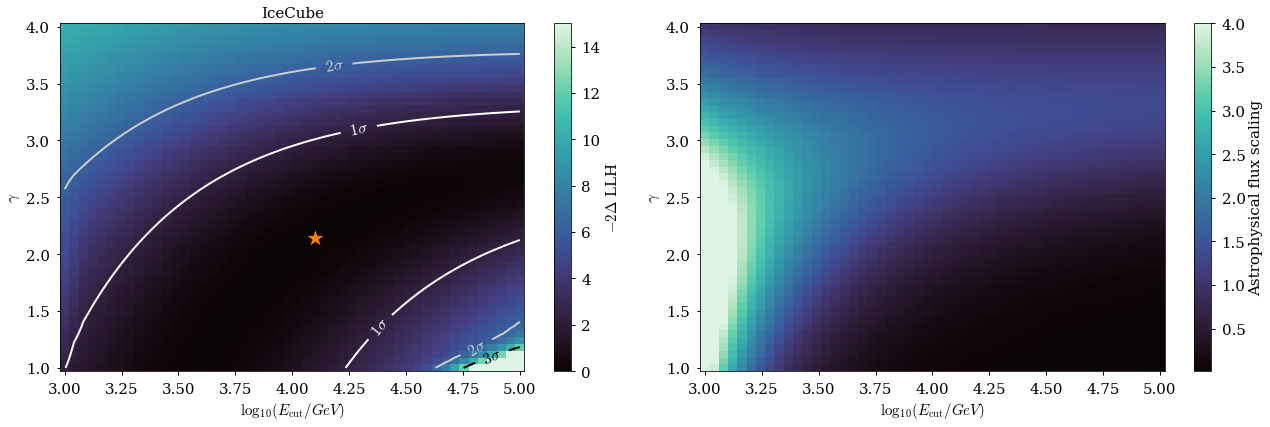

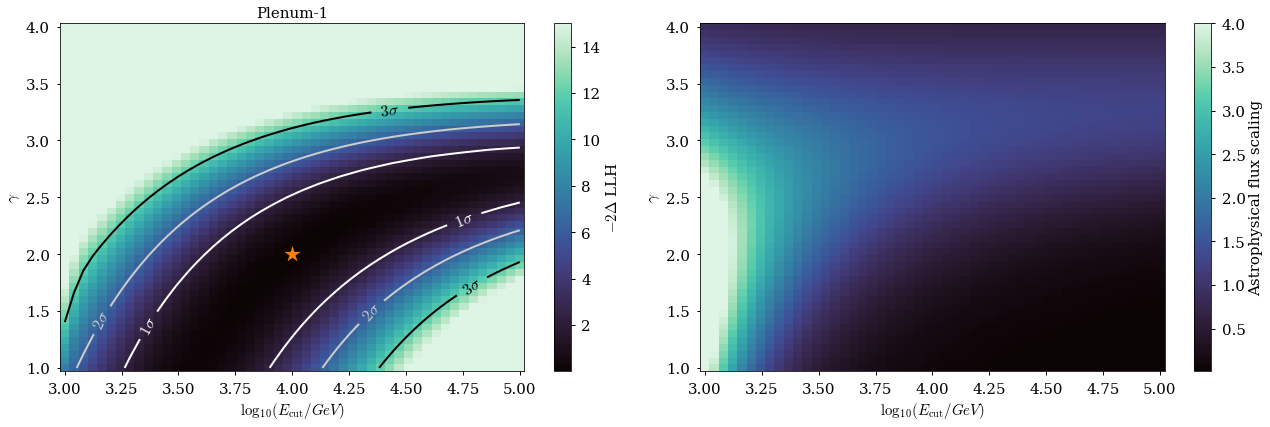

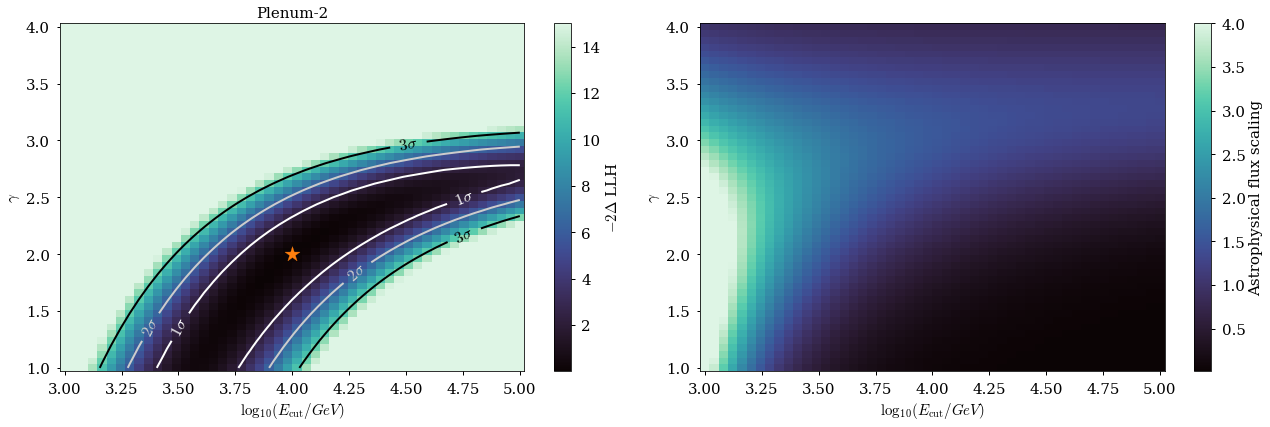

In [99]:
# confidence levels
cvals = 1 - erf(np.arange(1, 4) / np.sqrt(2))
levels = chi2.isf(cvals, 2)
lbs = np.array([r"$1\sigma$", r"$2\sigma$", r"$3\sigma$"])
level_colors = ["w", "0.8", "k"]

for ident in idents:
    print(ident)
    f, axes = plt.subplots(ncols=2, figsize=(18, 6))
    ax = axes[0]
    # draw llh grid for gamma and astro flux
    im = ax.pcolormesh(
        cut_scaling,
        gamma_astro_scaling,
        local_SPL["ts"][ident] - bf_SPL["ts"][ident],
        vmax=15,  # 6 is approx. the 95% quantile of a 2D LLH scan
    )
    cb = plt.colorbar(im, ax=ax)
    # draw contour levels

    sc = ax.contour(
        cut_scaling,
        gamma_astro_scaling,
        local_SPL["ts"][ident] - bf_SPL["ts"][ident],
        levels=levels,
        colors=level_colors,
    )
    ## best fit point
    ax.scatter(
        bf_SPL["cut"][ident],
        bf_SPL["gamma"][ident],
        marker="*",
        s=250,
        color="tab:orange",
    )
    fmt = {l: s for l, s in zip(sc.levels, lbs)}
    ax.clabel(sc, levels, fmt=fmt, fontsize=16)
    ax.set_xlabel(r"$\log_{10}(E_{\rm cut} / GeV)$")
    ax.set_ylabel(r"$\gamma$")
    cb.set_label(r"$-2 \Delta$ LLH")
    ax.set_title(ident)
    # ax.set_yscale("log")
    # ax.set_xscale("log")
    
    #ax.set_ylim(1e-12, 1e-10)
    #ax.set_xlim(1.7, 4)

    # in addition, check the "nuisance" parameter of astro flux normalization
    ax = axes[1]
    im = ax.pcolormesh(
        cut_scaling,
        gamma_astro_scaling,
        local_SPL["phi_astro"][ident],
    )
    ax.set_xlabel(r"$\log_{10}(E_{\rm cut} / GeV)$")
    ax.set_ylabel(r"$\gamma$")
    cb = plt.colorbar(im, ax=ax)
    cb.set_label(r"Astrophysical flux scaling")
    # ax.set_yscale("log")
    # ax.set_xscale("log")
    
    #ax.set_ylim(1e-12, 1e-10)
    #ax.set_xlim(1.7, 4)

    f.tight_layout()
    # f.savefig(f"../plots/2D_scan_diffuse_spl_{ident}.pdf")


# Cutoff significance versus time/detectors

Some options:
* 10yr IceCube
* 20yr IceCube
* 40yr IceCube
* 10yr IceCube + K3N
* 10yr IceCube + K3N + GVD
* 10yr IceCube + K3N + GVD + PONE
* 10yr IceCube +  2yr baseline Plenum (= IC + PONE + GVD + K3N)
* 10yr IceCube +  5yr baseline Plenum (= IC + PONE + GVD + K3N)
* 10yr IceCube + 10yr baseline Plenum (= IC + PONE + GVD + K3N)
* 10yr IceCube +  2yr Plenum-2 (= GEN2 + PONE + GVD + K3N)
* 10yr IceCube +  5yr Plenum-2 (= GEN2 + PONE + GVD + K3N)
* 10yr IceCube + 10yr Plenum-2 (= GEN2 + PONE + GVD + K3N)

In [126]:
# livetime relative to 10yrs
detector_configurations = [
    {
        "IceCube": 1.0,
        "Gen-2": 0,
        "Plenum-1": 0,
        "KM3NeT": 0,
        "P-ONE": 0,
        "Baikal-GVD": 0,
        "identifier": "10y IC",
    },
    {
        "IceCube": 2.0,
        "Gen-2": 0,
        "Plenum-1": 0,
        "KM3NeT": 0,
        "P-ONE": 0,
        "Baikal-GVD": 0,
        "identifier": "20y IC",
    },
    {
        "IceCube": 4.0,
        "Gen-2": 0,
        "Plenum-1": 0,
        "KM3NeT": 0,
        "P-ONE": 0,
        "Baikal-GVD": 0,
        "identifier": "40y IC",
    },
    {
        "IceCube": 1.0,
        "Gen-2": 0,
        "Plenum-1": 0.2,
        "KM3NeT": 0,
        "P-ONE": 0,
        "Baikal-GVD": 0,
        "identifier": "10y IC + 2y PL-1",
    },
    {
        "IceCube": 1.0,
        "Gen-2": 0,
        "Plenum-1": 0.5,
        "KM3NeT": 0,
        "P-ONE": 0,
        "Baikal-GVD": 0,
        "identifier": "10y IC + 5y PL-1",
    },
    {
        "IceCube": 1.0,
        "Gen-2": 0,
        "Plenum-1": 1,
        "KM3NeT": 0,
        "P-ONE": 0,
        "Baikal-GVD": 0,
        "identifier": "10y IC + 10y PL-1",
    },
    {
        "IceCube": 1.0,
        "Gen-2": 0.2,
        "Plenum-1": 0,
        "KM3NeT": 0.2,
        "P-ONE": 0.2,
        "Baikal-GVD": 0.2,
        "identifier": "10y IC + 2y PL-2",
    },
    {
        "IceCube": 1.0,
        "Gen-2": 0.5,
        "Plenum-1": 0,
        "KM3NeT": 0.5,
        "P-ONE": 0.5,
        "Baikal-GVD": 0.5,
        "identifier": "10y IC + 5y PL-2",
    },
    {
        "IceCube": 1.0,
        "Gen-2": 1,
        "Plenum-1": 0,
        "KM3NeT": 1,
        "P-ONE": 1,
        "Baikal-GVD": 1,
        "identifier": "10y IC + 10y PL-2",
    },
]
detector_configurations = pd.DataFrame(detector_configurations)


In [73]:
pvals = []
shape = "powerlaw with cutoff"

for idx, series in detector_configurations.iterrows():
    print(idx)
    aeff_factor = np.zeros_like(aeff_2d["IceCube"].T)
    naming = ""
    for ident, lt_factor in series.items():
        if ident == "identifier":
            continue
        if lt_factor == 0:
            continue
        print(ident)
        aeff_factor += (
            aeff_eval_e_sd(aeff_2d[ident], sindec_width, ewidth, ra_width)
            * LIVETIME
            * lt_factor
        )
    # asimov = expectation of perfect experiment
    k_i = asimov_data(aeff_factor, shape, verbose=verbose)

    # global min
    out = fmin_l_bfgs_b(
        spectral_ts_func,
        x0=shape_params[shape]["guess"],
        bounds=shape_params[shape]["bounds"],
        approx_grad=True,
        args=(aeff_factor, emids, E_NORM, k_i, shape),
    )
    # check that the TS at the fit minimum is close to the TS of the baseline params
    baseline_ts_check = np.isclose(
        out[1],
        spectral_ts_func(
            shape_params[shape]["baseline"], aeff_factor, emids, E_NORM, k_i, shape
        ),
        rtol=1e-2,
    )
    print("TS asimov check:", "OK" if baseline_ts_check else "not OK :(")
    # best fit powerlaw as null hypothesis
    out_pl = fmin_l_bfgs_b(
        spectral_ts_func,
        x0=shape_params["powerlaw"]["guess"],
        bounds=shape_params["powerlaw"]["bounds"],
        approx_grad=True,
        args=(aeff_factor, emids, E_NORM, k_i, "powerlaw"),
    )
    pval = chi2.sf(out_pl[1] - out[1], 1)
    sigma = erfinv(1 - pval) * np.sqrt(2)
    print("P-VALUE:", pval, ", SIGNIFICANCE:", sigma)
    pvals.append(
        {
            "identifier": series.identifier,  # str(idx) + ", " +
            "idx": idx,
            "pval": pval,
            r"Significance in $\sigma$": sigma,
        }
    )

pval_df = pd.DataFrame(pvals)
pval_df[r"$-\log_{10}$(p-value)"] = -np.log10(pval_df.pval)


0
IceCube
TS asimov check: OK
P-VALUE: 0.12926413859452204 , SIGNIFICANCE: 1.5170100819432395
1
IceCube
TS asimov check: OK
P-VALUE: 0.031922773434605145 , SIGNIFICANCE: 2.145376287557094
2
IceCube
TS asimov check: OK
P-VALUE: 0.0024135271016717578 , SIGNIFICANCE: 3.0339771492975123
3
IceCube
Plenum-1
TS asimov check: OK
P-VALUE: 0.0446249353123437 , SIGNIFICANCE: 2.008172771993524
4
IceCube
Plenum-1
TS asimov check: OK
P-VALUE: 0.01081084350412457 , SIGNIFICANCE: 2.5487543030802597
5
IceCube
Plenum-1
TS asimov check: OK
P-VALUE: 0.0008556532772905443 , SIGNIFICANCE: 3.3341343183502112
6
IceCube
Gen-2
KM3NeT
P-ONE
Baikal-GVD
TS asimov check: OK
P-VALUE: 0.008165339636952295 , SIGNIFICANCE: 2.6451554487693167
7
IceCube
Gen-2
KM3NeT
P-ONE
Baikal-GVD
TS asimov check: OK
P-VALUE: 0.0001775712750388557 , SIGNIFICANCE: 3.7489573532579943
8
IceCube
Gen-2
KM3NeT
P-ONE
Baikal-GVD
TS asimov check: OK
P-VALUE: 3.746315740516544e-07 , SIGNIFICANCE: 5.0814160494699


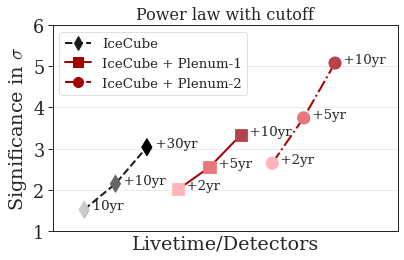

In [76]:
### plot significance vs livetime/detector configs
f, ax = plt.subplots()
label_size = "x-small"
# ICECUBE
ax.plot(
    pval_df.loc[[0, 1, 2]]["identifier"],
    pval_df.loc[[0, 1, 2]][r"Significance in $\sigma$"],
    ls=contour_formats["IceCube"]["linestyles"],
    color=poles["IceCube"]["color"],
    marker="d",
    label="IceCube",
    ms=10,
)
ax.scatter(
    x=pval_df.loc[[0, 1, 2]]["identifier"],
    y=pval_df.loc[[0, 1, 2]][r"Significance in $\sigma$"],
    c=many_colors[:3],
    s=150,
    zorder=10,
    marker="d",
)
ax.text(
    x=pval_df.loc[0]["identifier"],
    y=pval_df.loc[0][r"Significance in $\sigma$"],
    s="  10yr",
    fontsize=label_size,
)
ax.text(
    x=pval_df.loc[1]["identifier"],
    y=pval_df.loc[1][r"Significance in $\sigma$"],
    s="  +10yr",
    fontsize=label_size,
)
ax.text(
    x=pval_df.loc[2]["identifier"],
    y=pval_df.loc[2][r"Significance in $\sigma$"],
    s="  +30yr",
    fontsize=label_size,
)

## PLENUM-1
ax.plot(
    pval_df.loc[[3, 4, 5]]["identifier"],
    pval_df.loc[[3, 4, 5]][r"Significance in $\sigma$"],
    ls=poles["Plenum-1"]["ls"],
    color=poles["Plenum-1"]["color"],
    marker="s",
    label="IceCube + Plenum-1",
    ms=10,
)
ax.scatter(
    x=pval_df.loc[[3, 4, 5]]["identifier"],
    y=pval_df.loc[[3, 4, 5]][r"Significance in $\sigma$"],
    c=many_colors[3:6],
    s=150,
    zorder=10,
    marker="s",
)
ax.text(
    x=pval_df.loc[3]["identifier"],
    y=pval_df.loc[3][r"Significance in $\sigma$"],
    s="  +2yr",
    fontsize=label_size,
)
ax.text(
    x=pval_df.loc[4]["identifier"],
    y=pval_df.loc[4][r"Significance in $\sigma$"],
    s="  +5yr",
    fontsize=label_size,
)
ax.text(
    x=pval_df.loc[5]["identifier"],
    y=pval_df.loc[5][r"Significance in $\sigma$"],
    s="  +10yr",
    fontsize=label_size,
)


## PLENUM-2
ax.plot(
    pval_df.loc[[6, 7, 8]]["identifier"],
    pval_df.loc[[6, 7, 8]][r"Significance in $\sigma$"],
    ls=poles["Plenum-2"]["ls"],
    color=poles["Plenum-2"]["color"],
    marker="o",
    label="IceCube + Plenum-2",
    ms=10,
)
ax.scatter(
    x=pval_df.loc[[6, 7, 8]]["identifier"],
    y=pval_df.loc[[6, 7, 8]][r"Significance in $\sigma$"],
    c=many_colors[3:6],
    s=150,
    zorder=10,
    marker="o",
)
ax.text(
    x=pval_df.loc[6]["identifier"],
    y=pval_df.loc[6][r"Significance in $\sigma$"],
    s="  +2yr",
    fontsize=label_size,
)
ax.text(
    x=pval_df.loc[7]["identifier"],
    y=pval_df.loc[7][r"Significance in $\sigma$"],
    s="  +5yr",
    fontsize=label_size,
)
ax.text(
    x=pval_df.loc[8]["identifier"],
    y=pval_df.loc[8][r"Significance in $\sigma$"],
    s="  +10yr",
    fontsize=label_size,
)

ax.set_xlim(-1, 10)
ax.set_ylim(1, 6)
ax.set_xticks([])
ax.legend(fontsize="x-small")
ax.set_title("Power law with cutoff", fontsize="small")
ax.set_xlabel("Livetime/Detectors")
ax.set_ylabel(r"Significance in $\sigma$")
plt.tight_layout()
plt.savefig("../plots/cutoff_sigma_vs_det_talk.pdf")


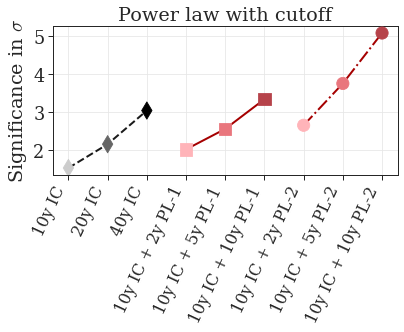

In [78]:
# same plot, alternative labeling as in PoS(ICRC2021)1185
f, ax = plt.subplots(figsize=(6, 5))

ax.plot(
    pval_df.loc[[0, 1, 2]]["identifier"],
    pval_df.loc[[0, 1, 2]][r"Significance in $\sigma$"],
    ls=contour_formats["IceCube"]["linestyles"],
    color=poles["IceCube"]["color"],
)
ax.scatter(
    x=pval_df.loc[[0, 1, 2]]["identifier"],
    y=pval_df.loc[[0, 1, 2]][r"Significance in $\sigma$"],
    c=many_colors[:3],
    s=150,
    zorder=10,
    marker="d",
)

ax.plot(
    pval_df.loc[[3, 4, 5]]["identifier"],
    pval_df.loc[[3, 4, 5]][r"Significance in $\sigma$"],
    ls=poles["Plenum-1"]["ls"],
    color=poles["Plenum-1"]["color"],
)
ax.scatter(
    x=pval_df.loc[[3, 4, 5]]["identifier"],
    y=pval_df.loc[[3, 4, 5]][r"Significance in $\sigma$"],
    c=many_colors[3:6],
    s=150,
    zorder=10,
    marker="s",
)

ax.plot(
    pval_df.loc[[6, 7, 8]]["identifier"],
    pval_df.loc[[6, 7, 8]][r"Significance in $\sigma$"],
    ls=poles["Plenum-2"]["ls"],
    color=poles["Plenum-2"]["color"],
)
ax.scatter(
    x=pval_df.loc[[6, 7, 8]]["identifier"],
    y=pval_df.loc[[6, 7, 8]][r"Significance in $\sigma$"],
    c=many_colors[3:6],
    s=150,
    zorder=10,
    marker="o",
)


# ax.set_ylim(0, 5.5)
ax.set_title("Power law with cutoff")
ax.set_xlabel("")
ax.set_ylabel(r"Significance in $\sigma$")
plt.xticks(rotation=65, fontsize="small", ha="right")
plt.tight_layout()
plt.savefig("../plots/cutoff_sigma_vs_det.pdf")


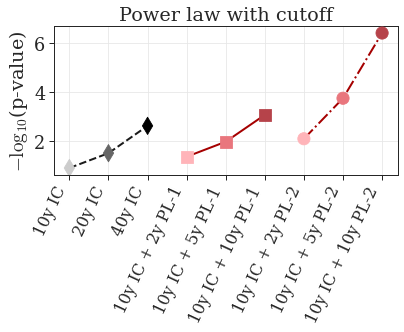

In [79]:
f, ax = plt.subplots(figsize=(6, 5))
ax.plot(
    pval_df.loc[[0, 1, 2]]["identifier"],
    pval_df.loc[[0, 1, 2]][r"$-\log_{10}$(p-value)"],
    ls=contour_formats["IceCube"]["linestyles"],
    color=poles["IceCube"]["color"],
)
ax.scatter(
    x=pval_df.loc[[0, 1, 2]]["identifier"],
    y=pval_df.loc[[0, 1, 2]][r"$-\log_{10}$(p-value)"],
    c=many_colors[:3],
    s=150,
    zorder=10,
    marker="d",
)

ax.plot(
    pval_df.loc[[3, 4, 5]]["identifier"],
    pval_df.loc[[3, 4, 5]][r"$-\log_{10}$(p-value)"],
    ls=poles["Plenum-1"]["ls"],
    color=poles["Plenum-1"]["color"],
)
ax.scatter(
    x=pval_df.loc[[3, 4, 5]]["identifier"],
    y=pval_df.loc[[3, 4, 5]][r"$-\log_{10}$(p-value)"],
    c=many_colors[3:6],
    s=150,
    zorder=10,
    marker="s",
)

ax.plot(
    pval_df.loc[[6, 7, 8]]["identifier"],
    pval_df.loc[[6, 7, 8]][r"$-\log_{10}$(p-value)"],
    ls=poles["Plenum-2"]["ls"],
    color=poles["Plenum-2"]["color"],
)
ax.scatter(
    x=pval_df.loc[[6, 7, 8]]["identifier"],
    y=pval_df.loc[[6, 7, 8]][r"$-\log_{10}$(p-value)"],
    c=many_colors[3:6],
    s=150,
    zorder=10,
    marker="o",
)

ax.set_title("Power law with cutoff")
ax.set_xlabel("")
ax.set_ylabel(r"$-\log_{10}$(p-value)")
plt.xticks(rotation=65, fontsize="small", ha="right")
plt.tight_layout()
plt.savefig("../plots/cutoff_pval_vs_det.pdf")


## Significance vs cutoff value

In [80]:
print_names = {
    "IceCube": "IceCube",
    "Plenum-1": r"IceCube + PLE$\nu$M-1",
    "Plenum-2": r"IceCube + PLE$\nu$M-2",
}


In [81]:
pvals = []
cutoff_vals = np.round(np.arange(5.0, 8.1, step=0.2), 1)
for e_cut in cutoff_vals:
    for li, ident in enumerate(idents):
        shape = "powerlaw with cutoff"
        aeff_factor = (
            aeff_eval_e_sd(aeff_2d[ident], sindec_width, ewidth, ra_width) * LIVETIME
        )
        if "Plenum" in ident:
            aeff_factor += (
                aeff_eval_e_sd(aeff_2d["IceCube"], sindec_width, ewidth, ra_width)
                * LIVETIME
            )
        # asimov = expectation of perfect experiment
        shp_params = np.copy(shape_params[shape]["baseline"])
        shp_params[-1] = e_cut
        k_i = asimov_data(aeff_factor, shape, verbose=False, shp_params=shp_params)

        # global min
        out = fmin_l_bfgs_b(
            spectral_ts_func,
            x0=shape_params[shape]["guess"],
            bounds=shape_params[shape]["bounds"],
            approx_grad=True,
            args=(aeff_factor, emids, E_NORM, k_i, shape),
        )
        # check that the TS at the fit minimum is close to the TS of the baseline params
        reference = spectral_ts_func(shp_params, aeff_factor, emids, E_NORM, k_i, shape)
        baseline_ts_check = np.isclose(out[1], reference, rtol=1e-2)
        print("TS asimov check:", "OK" if baseline_ts_check else "not OK :(")
        if not baseline_ts_check:
            print("e_cut:", shp_params[-1])
            print("fit: ", out[1], ", reference:", reference)
        # best fit powerlaw as null hypothesis
        out_pl = fmin_l_bfgs_b(
            spectral_ts_func,
            x0=shape_params["powerlaw"]["guess"],
            bounds=shape_params["powerlaw"]["bounds"],
            approx_grad=True,
            args=(aeff_factor, emids, E_NORM, k_i, "powerlaw"),
        )
        pval = chi2.sf(out_pl[1] - out[1], 1)
        significance = erfinv(1 - pval) * np.sqrt(2)
        # print("P-VALUE:", pval, ", SIGNIFICANCE:", significance)
        pvals.append(
            {
                "ident": print_names[ident],
                "pval": pval,
                r"Significance in $\sigma$": significance,
                r"$\log_{10}(E_{\rm cut}/{\rm GeV})$": e_cut,
                r"Conv_PL": out_pl[0][0],
                r"$\gamma_{PL}$": out_pl[0][1],
                r"$\Phi_{0,PL}$": out_pl[0][2],
                r"Conv": out[0][0],
                r"$\gamma$": out[0][1],
                r"$\Phi_{0}$": out[0][2],
                r"$E_{\rm cut}$": out[0][3],
            }
        )

pval_df = pd.DataFrame(pvals)
pval_df[r"$-\log_{10}$(p-value)"] = -np.log10(pval_df.pval)


TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK
TS asimov check: OK


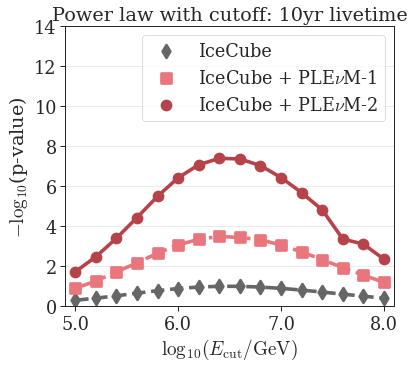

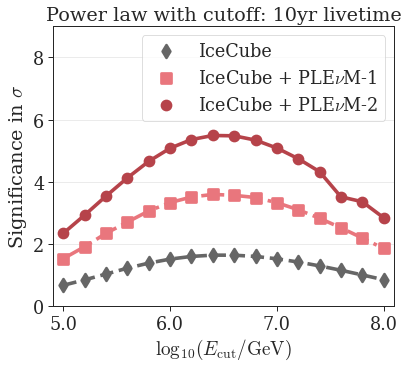

In [95]:
f, ax = plt.subplots(figsize=(6, 5.5))
ax = sns.pointplot(
    data=pval_df,
    hue="ident",
    ax=ax,
    y=r"$-\log_{10}$(p-value)",
    x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$",
    palette=many_colors[[1, 4, 5]],
    linestyles=["--", "-.", "-"],
    markers=["d", "s", "o"],
)
ax.set_title("Power law with cutoff: 10yr livetime")
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=1)  # , fontsize="x-small")
ax.set_ylim(0, 14)
plt.tight_layout()
plt.savefig("../plots/cutoff_pval_vs_cutoff.pdf")

f, ax = plt.subplots(figsize=(6, 5.5))
ax = sns.pointplot(
    data=pval_df,
    hue="ident",
    ax=ax,
    y=r"Significance in $\sigma$",
    x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$",
    palette=many_colors[[1, 4, 5]],
    linestyles=["--", "-.", "-"],
    markers=["d", "s", "o"],
)
ax.set_title("Power law with cutoff: 10yr livetime")
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=1)  # , fontsize="x-small")
ax.set_ylim(0, 9)
f.tight_layout()
plt.savefig("../plots/cutoff_sigma_vs_cutoff.pdf")


## check that parameter fits are ok

In [92]:
plot_kw = dict(
    palette=many_colors[[1, 4, 5]],
    linestyles=["-", "-.", "-"],
    markers=["d", "s", "o"],
)


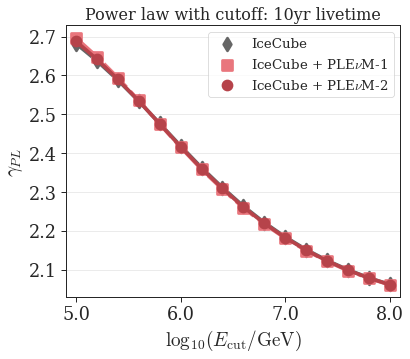

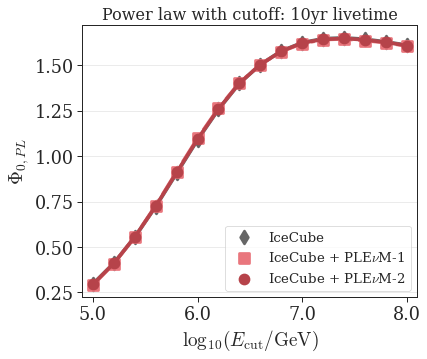

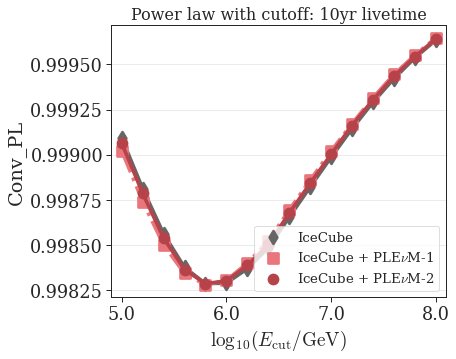

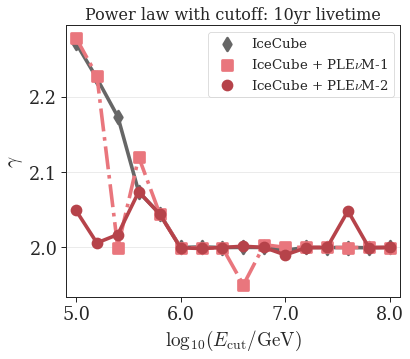

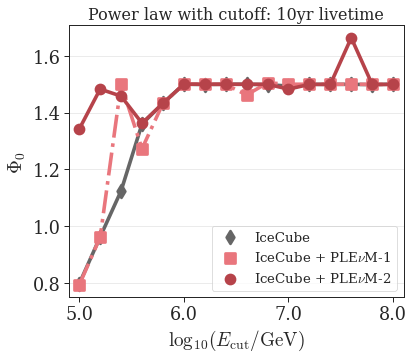

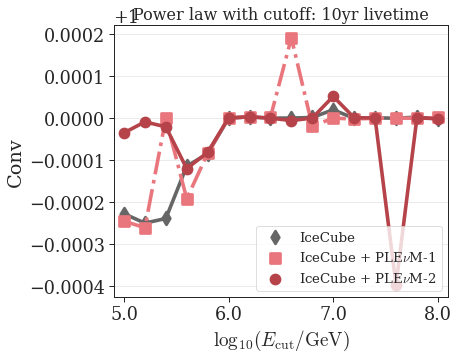

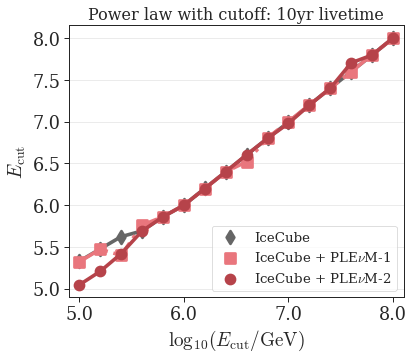

In [93]:
f, ax = plt.subplots(figsize=(6, 5))
ax = sns.pointplot(
    data=pval_df,
    hue="ident",
    ax=ax,
    y=r"$\gamma_{PL}$",
    x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$",
    **plot_kw
)
ax.set_title("Power law with cutoff: 10yr livetime", fontsize="small")
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=1, fontsize="x-small")

f, ax = plt.subplots(figsize=(6, 5))
ax = sns.pointplot(
    data=pval_df,
    hue="ident",
    ax=ax,
    y=r"$\Phi_{0,PL}$",
    x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$",
    **plot_kw
)
ax.set_title("Power law with cutoff: 10yr livetime", fontsize="small")
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=4, fontsize="x-small")

f, ax = plt.subplots(figsize=(6, 5))
ax = sns.pointplot(
    data=pval_df,
    hue="ident",
    ax=ax,
    y=r"Conv_PL",
    x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$",
    **plot_kw
)
ax.set_title("Power law with cutoff: 10yr livetime", fontsize="small")
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=4, fontsize="x-small")

f, ax = plt.subplots(figsize=(6, 5))
ax = sns.pointplot(
    data=pval_df,
    hue="ident",
    ax=ax,
    y=r"$\gamma$",
    x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$",
    **plot_kw
)
ax.set_title("Power law with cutoff: 10yr livetime", fontsize="small")
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=1, fontsize="x-small")

f, ax = plt.subplots(figsize=(6, 5))
ax = sns.pointplot(
    data=pval_df,
    hue="ident",
    ax=ax,
    y=r"$\Phi_{0}$",
    x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$",
    **plot_kw
)
ax.set_title("Power law with cutoff: 10yr livetime", fontsize="small")
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=4, fontsize="x-small")

f, ax = plt.subplots(figsize=(6, 5))
ax = sns.pointplot(
    data=pval_df,
    hue="ident",
    ax=ax,
    y=r"Conv",
    x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$",
    **plot_kw
)
ax.set_title("Power law with cutoff: 10yr livetime", fontsize="small")
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=4, fontsize="x-small")

f, ax = plt.subplots(figsize=(6, 5))
ax = sns.pointplot(
    data=pval_df,
    hue="ident",
    ax=ax,
    y=r"$E_{\rm cut}$",
    x=r"$\log_{10}(E_{\rm cut}/{\rm GeV})$",
    **plot_kw
)
ax.set_title("Power law with cutoff: 10yr livetime", fontsize="small")
ax.set_xticks(np.arange(0, len(cutoff_vals), step=5))
ax.legend(loc=4, fontsize="x-small")
